In [ ]:
import os
import pandas as pd
import shap
import joblib
import lightgbm as lgb
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.inspection import permutation_importance
import numpy as np


In [ ]:
path = './dataset'

## Setting fore reforecast

In [ ]:
a = [1,2,4,5,6,7,8]

operation_hours_array = [
      ('06:00', '21:30'),
      ('00:00', '23:59'),
      ('00:00', '23:59'),
      ('00:00', '23:59'),
      ('06:00', '21:00'),
      ('06:00', '21:00'),
      ('06:00', '19:00')
  ]

best_model_tuples = [
    ('svr', 'svr'),
    ('lgb', 'svr'),
    ('mlr', 'svr'),
    ('mlr', 'svr'),
    ('mlr', 'svr'),
    ('mlr', 'svr'),
    ('lgb', 'svr')
]

features = ['Total solar irradiance (W/m2)',
       'Air temperature  (°C) ', 'Atmosphere (hpa)',
       'Power (MW)', 'hour_sin', 'hour_cos', 'month_sin',
       'month_cos', 'same_time_mean', 'same_time_std', 'same_time_max',
       'same_time_min', 'same_weekday_mean', 'same_weekday_std',
       'same_weekday_max', 'same_weekday_min', 'overall_mean', 'overall_std',
       'overall_max', 'overall_min', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'diff_15min', 'diff_30min',
       'diff_45min', 'diff_60min', 'diff_75min', 'diff_90min', 'diff_105min']


test_size = 2/24


shap_values_list = []


## Reforecast test

In [ ]:
from sklearn.preprocessing import MinMaxScaler


# reforecast shap
for i, df_index in enumerate(a):
  print('----------------------------------------------------------------------------------')
  forecast_model,reforecast_model = best_model_tuples[i]
  start_str, end_str = operation_hours_array[i]

  file = [os.path.join(path+'/result_of_paper/22mon_reforecast_data/', file) for file in os.listdir(path+'/result_of_paper/22mon_reforecast_data/') if file.endswith('.csv') and f'{forecast_model}' in file and f'{str(df_index)}' in file][0]
  print(file)
  df = pd.read_csv(file)

  forecast_model,reforecast_model = best_model_tuples[i]
  start_str, end_str = operation_hours_array[i]
  target = f'error_{forecast_model}'
  shifted_target = f'error_{forecast_model}_shifted'

  df[shifted_target] = df[target].shift(-1)
  df = df.dropna().reset_index(drop=True)

  split_index = int(len(df) * (1 - test_size))

  added_features = features.copy() + [f'pred_{forecast_model}', f'error_{forecast_model}']
  added_features = [col for col in added_features if col in df.columns]
  X = df[added_features]
  y = df[shifted_target]
  X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
  y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
  X_test_scaled = scaler.transform(X_test)
  X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

  # 데이터: X_train, X_test, y_train 필요
  # 모델 불러오기
  reforecast_mlr = joblib.load(f"{path}/result_of_paper/22mon_reforecast_data/mlr_reforecasting_model_{forecast_model}_forecast_{str(df_index)}.joblib")
  reforecast_svr = joblib.load(f"{path}/result_of_paper/22mon_reforecast_data/svr_reforecasting_model_{forecast_model}_forecast_{str(df_index)}.joblib")
  reforecast_lgb_model = lgb.Booster(model_file=f"{path}/result_of_paper/22mon_reforecast_data/lgb_reforecasting_model_{forecast_model}_forecast_{str(df_index)}.txt")

  if reforecast_model == 'mlr':
    # ------------------- MLR -------------------
    explainer_mlr = shap.Explainer(reforecast_mlr, X_train_scaled_df)
    shap_values_mlr = explainer_mlr(X_train_scaled_df)

    shap.summary_plot(shap_values_mlr, X_train_scaled_df)
    shap.plots.bar(shap_values_mlr)

    # ▶ MLR Feature Importance
    mlr_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': reforecast_mlr.coef_
    }).sort_values('importance', key=abs, ascending=False)

    print("\n[MLR Feature Importance]")
    print(mlr_importance)

  elif reforecast_model == 'svr':
    # ------------------- SVR -------------------
    svr_result = permutation_importance(reforecast_svr, X_train_scaled_df, y_train, n_repeats=5,n_jobs=-1, random_state=0)

    svr_importance = pd.DataFrame({
        'feature': X_train_scaled_df.columns,
        'importance': svr_result.importances_mean
    }).sort_values('importance', ascending=False)

    print("\n[SVR Feature Importance (Permutation)]")
    print(svr_importance)

    top_n = 20
    top_features = svr_importance.head(top_n)

    plt.figure(figsize=(8, 6))
    plt.barh(top_features['feature'], top_features['importance'], color='salmon')
    plt.xlabel('Permutation Importance')
    plt.title(f'SVR Feature Importance (Top {top_n})')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

  elif reforecast_model == 'lgb':
  # ------------------- LGB -------------------
    explainer_lgb = shap.Explainer(reforecast_lgb_model)
    shap_values_lgb = explainer_lgb(X_train)

    shap_importance = np.abs(shap_values_lgb.values).mean(axis=0)

    # DataFrame으로 정리
    shap_df = pd.DataFrame({
        'feature': X_test.columns,
        'mean_abs_shap': shap_importance
    }).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

    # 출력
    for _, row in shap_df.iterrows():
        print(f"{row['feature']}: {row['mean_abs_shap']:.6f}")

    # kneedle 알고리즘 사용
    x = np.arange(len(shap_df))
    y = shap_df['mean_abs_shap'].values
    x_scaled = MinMaxScaler().fit_transform(x.reshape(-1, 1)).flatten()
    y_scaled = MinMaxScaler().fit_transform(y.reshape(-1, 1)).flatten()

    # 직선 시작점과 끝점
    start = np.array([x_scaled[0], y_scaled[0]])
    end = np.array([x_scaled[-1], y_scaled[-1]])

    # 각 점에서 직선까지의 수직 거리 계산
    line_vec = end - start
    line_vec_norm = line_vec / np.linalg.norm(line_vec)
    point_vecs = np.stack([x_scaled - start[0], y_scaled - start[1]], axis=1)
    projections = np.dot(point_vecs, line_vec_norm)
    projected_points = np.outer(projections, line_vec_norm) + start
    distances = np.linalg.norm(point_vecs - projected_points, axis=1)

    # 가장 멀리 떨어진 점이 elbow point
    elbow_idx = np.argmax(distances)
    elbow_feature = shap_df.loc[elbow_idx, 'feature']
    elbow_value = shap_df.loc[elbow_idx, 'mean_abs_shap']

    # 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o', label='SHAP importance', linewidth=2)
    plt.scatter(elbow_idx, elbow_value, color='red', marker='*', s=300, label=f'Elbow Point: {elbow_feature}')
    plt.title("SHAP Feature Importance with Elbow Point (Distance Method)")
    plt.xlabel("Feature Rank")
    plt.ylabel("Mean |SHAP value|")
    plt.legend()
    plt.grid(True)
    plt.show()

## Reforecast train for all models

In [ ]:
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from sklearn.utils import resample

def compute_feature_importance(f, X, base_pred, model, n_repeats, rng):
    feature_diffs = []
    for _ in range(n_repeats):
        X_permuted = X.copy()
        X_permuted[f] = rng.permutation(X_permuted[f].values)
        pred_permuted = model.predict(X_permuted.values)
        diff = np.abs(base_pred - pred_permuted)
        feature_diffs.append(diff)
    return f, np.mean(np.stack(feature_diffs), axis=0)

def permutation_importance_per_instance(columns, model, X, n_repeats=5, random_state=42, n_jobs=-1):
    rng = np.random.RandomState(random_state)
    X = X.copy()
    base_pred = model.predict(X.values)
    results = Parallel(n_jobs=n_jobs)(
        delayed(compute_feature_importance)(f, X, base_pred, model, n_repeats, rng)
        for f in columns
    )
    return {f: v for f, v in results}


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
import multiprocessing



forecast_models = ['mlr','svr','lgb', 'mlp']
reforecast_models = ['mlr','svr','lgb', 'mlp']

mlr_files = sorted([os.path.join(path+'/result_of_paper/ann/', file) for file in os.listdir(path+'/result_of_paper/ann/') if file.endswith('.csv') and 'mlr' in file])
svr_files = sorted([os.path.join(path+'/result_of_paper/ann/', file) for file in os.listdir(path+'/result_of_paper/ann/') if file.endswith('.csv') and 'svr' in file])
lgb_files = sorted([os.path.join(path+'/result_of_paper/ann/', file) for file in os.listdir(path+'/result_of_paper/ann/') if file.endswith('.csv') and 'lgb' in file])
mlp_files = sorted([os.path.join(path+'/result_of_paper/ann/', file) for file in os.listdir(path+'/result_of_paper/ann/') if file.endswith('.csv') and 'mlp' in file])

mlr_df_list = []
svr_df_list = []
lgb_df_list = []
mlp_df_list = []

for file in mlr_files:
  mlr_df_list.append(pd.read_csv(file))
for file in svr_files:
  svr_df_list.append(pd.read_csv(file))
for file in lgb_files:
  lgb_df_list.append(pd.read_csv(file))
for file in mlp_files:
  mlp_df_list.append(pd.read_csv(file))


test_size = 2/24

df_lists=[mlr_df_list, svr_df_list,lgb_df_list, mlp_df_list]

for forecast_model, df_list in zip(forecast_models, df_lists):
  print('==============================================================================================')
  print(f'forecast_model : {forecast_model.upper()}')

  for df, site in zip(df_list, [1,2,4,5,6,7,8]):
    print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    print(f'site : {site}')
    target = f'error_{forecast_model}'
    shifted_target = f'{target}_shifted'

    for reforecast_model in reforecast_models:
      print('--------------------------------------------------------------------------------------------------------------------------------')

      df_copy = df.copy()
      df_copy[shifted_target] = df_copy[target].shift(-1)
      df_copy = df_copy.dropna().reset_index(drop=True)

      split_index = int(len(df_copy) * (1 - test_size))

      added_features = features.copy() + [f'error_{forecast_model}', f'pred_{forecast_model}']
      added_features = [col for col in added_features if col in df_copy.columns]
      X = df_copy[added_features]
      y = df_copy[shifted_target]
      X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
      y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

      scaler = StandardScaler()
      X_train_scaled = scaler.fit_transform(X_train)
      X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
      X_test_scaled = scaler.transform(X_test)
      X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

      reforecast_mlr = joblib.load(f"{path}/result_of_paper/ann/mlr_reforecasting_model_{forecast_model}_forecast_{str(site)}.joblib")
      reforecast_svr = joblib.load(f"{path}/result_of_paper/ann/svr_reforecasting_model_{forecast_model}_forecast_{str(site)}.joblib")
      reforecast_lgb_model = lgb.Booster(model_file=f"{path}/result_of_paper/ann/lgb_reforecasting_model_{forecast_model}_forecast_{str(site)}.txt")
      reforecast_mlp = joblib.load(f"{path}/result_of_paper/ann/mlp_reforecasting_model_{forecast_model}_forecast_{site}.joblib")


      if reforecast_model == 'mlr':
          # ------------------- MLR -------------------
          explainer_mlr = shap.Explainer(reforecast_mlr, X_train_scaled_df)
          shap_values_mlr = explainer_mlr(X_train_scaled_df)

          shap_importance = np.abs(shap_values_mlr.values).mean(axis=0)

          shap_df = pd.DataFrame({
              'feature': X_train.columns,
              'mean_abs_shap': shap_importance
          }).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

          print("\n[MLR Feature Importance (SHAP)]")
          for _, row in shap_df.iterrows():
            print(f"{row['feature']}: {row['mean_abs_shap']:.6f}")

          # elbow point
          x = np.arange(len(shap_df))
          y = shap_df['mean_abs_shap'].values
          x_scaled = MinMaxScaler().fit_transform(x.reshape(-1, 1)).flatten()
          y_scaled = MinMaxScaler().fit_transform(y.reshape(-1, 1)).flatten()

          start = np.array([x_scaled[0], y_scaled[0]])
          end = np.array([x_scaled[-1], y_scaled[-1]])

          line_vec = end - start
          line_vec_norm = line_vec / np.linalg.norm(line_vec)
          point_vecs = np.stack([x_scaled - start[0], y_scaled - start[1]], axis=1)
          projections = np.dot(point_vecs, line_vec_norm)
          projected_points = np.outer(projections, line_vec_norm) + start
          distances = np.linalg.norm(point_vecs - projected_points, axis=1)

          elbow_idx = np.argmax(distances)
          elbow_feature = shap_df.loc[elbow_idx, 'feature']
          elbow_value = shap_df.loc[elbow_idx, 'mean_abs_shap']

          plt.figure(figsize=(10, 6))
          plt.plot(x, y, marker='o', label='SHAP importance', linewidth=2)
          plt.scatter(elbow_idx, elbow_value, color='red', marker='*', s=300, label=f'Elbow Point: {elbow_feature}')
          plt.title("MLR SHAP Feature Importance with Elbow Point")
          plt.xlabel("Feature Rank")
          plt.ylabel("Mean |SHAP value|")
          plt.legend()
          plt.grid(True)
          plt.show()

          shap.summary_plot(shap_values_mlr, X_train_scaled_df, plot_type="dot", show=True)


      elif reforecast_model == 'svr':
          # ------------------- SVR -------------------
          X_sample_df, y_sample = resample(X_train_scaled_df, y_train, n_samples=5000, random_state=42)
          importance_dict = permutation_importance_per_instance(
              columns=X_sample_df.columns,
              model=reforecast_svr,
              X=X_sample_df,
              n_repeats=5,
              n_jobs=-1  # 모든 CPU 코어 사용
          )

          # ▶ 평균 중요도로 정리
          shap_style_df = pd.DataFrame({
              'feature': X_sample_df.columns,
              'mean_abs_shap': [np.mean(np.abs(v)) for v in importance_dict.values()]
          }).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

          # ▶ 출력
          for _, row in shap_style_df.iterrows():
              print(f"{row['feature']}: {row['mean_abs_shap']:.6f}")

          # elbow point
          x = np.arange(len(shap_style_df))
          y = shap_style_df['mean_abs_shap'].values
          x_scaled = MinMaxScaler().fit_transform(x.reshape(-1, 1)).flatten()
          y_scaled = MinMaxScaler().fit_transform(y.reshape(-1, 1)).flatten()

          start = np.array([x_scaled[0], y_scaled[0]])
          end = np.array([x_scaled[-1], y_scaled[-1]])

          line_vec = end - start
          line_vec_norm = line_vec / np.linalg.norm(line_vec)
          point_vecs = np.stack([x_scaled - start[0], y_scaled - start[1]], axis=1)
          projections = np.dot(point_vecs, line_vec_norm)
          projected_points = np.outer(projections, line_vec_norm) + start
          distances = np.linalg.norm(point_vecs - projected_points, axis=1)

          elbow_idx = np.argmax(distances)
          elbow_feature = shap_style_df.loc[elbow_idx, 'feature']
          elbow_value = shap_style_df.loc[elbow_idx, 'mean_abs_shap']

          plt.figure(figsize=(10, 6))
          plt.plot(x, y, marker='o', label='SHAP importance', linewidth=2)
          plt.scatter(elbow_idx, elbow_value, color='red', marker='*', s=300, label=f'Elbow Point: {elbow_feature}')
          plt.title("SVR SHAP Feature Importance with Elbow Point")
          plt.xlabel("Feature Rank")
          plt.ylabel("Mean |SHAP value|")
          plt.legend()
          plt.grid(True)
          plt.show()

          svr_array = np.stack([v for v in importance_dict.values()], axis=-1)
          shap.summary_plot(svr_array, X_sample_df, plot_type="dot", show=True)


      elif reforecast_model == 'lgb':
      # ------------------- LGB -------------------explainer_lgb = shap.Explainer(reforecast_lgb_model)

        explainer_lgb = shap.Explainer(reforecast_lgb_model)
        shap_values_lgb = explainer_lgb(X_train)

        shap_importance = np.abs(shap_values_lgb.values).mean(axis=0)

        # DataFrame으로 정리
        shap_df = pd.DataFrame({
            'feature': X_test.columns,
            'mean_abs_shap': shap_importance
        }).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

        # 출력
        print("\n[LGB Feature Importance (SHAP)]")
        for _, row in shap_df.iterrows():
            print(f"{row['feature']}: {row['mean_abs_shap']:.6f}")

        # kneedle 알고리즘 사용
        x = np.arange(len(shap_df))
        y = shap_df['mean_abs_shap'].values
        x_scaled = MinMaxScaler().fit_transform(x.reshape(-1, 1)).flatten()
        y_scaled = MinMaxScaler().fit_transform(y.reshape(-1, 1)).flatten()

        # 직선 시작점과 끝점
        start = np.array([x_scaled[0], y_scaled[0]])
        end = np.array([x_scaled[-1], y_scaled[-1]])

        # 각 점에서 직선까지의 수직 거리 계산
        line_vec = end - start
        line_vec_norm = line_vec / np.linalg.norm(line_vec)
        point_vecs = np.stack([x_scaled - start[0], y_scaled - start[1]], axis=1)
        projections = np.dot(point_vecs, line_vec_norm)
        projected_points = np.outer(projections, line_vec_norm) + start
        distances = np.linalg.norm(point_vecs - projected_points, axis=1)

        # 가장 멀리 떨어진 점이 elbow point
        elbow_idx = np.argmax(distances)
        elbow_feature = shap_df.loc[elbow_idx, 'feature']
        elbow_value = shap_df.loc[elbow_idx, 'mean_abs_shap']

        # 시각화
        plt.figure(figsize=(10, 6))
        plt.plot(x, y, marker='o', label='SHAP importance', linewidth=2)
        plt.scatter(elbow_idx, elbow_value, color='red', marker='*', s=300, label=f'Elbow Point: {elbow_feature}')
        plt.title("SHAP Feature Importance with Elbow Point (Distance Method)")
        plt.xlabel("Feature Rank")
        plt.ylabel("Mean |SHAP value|")
        plt.legend()
        plt.grid(True)
        plt.show()

        shap.summary_plot(shap_values_lgb, X_train, plot_type="dot", show=True)


      elif reforecast_model == 'mlp':
        # ------------------- MLP -------------------
        def compute_shap_partial(batch):
            explainer = shap.KernelExplainer(reforecast_mlp.predict, background)
            return explainer.shap_values(batch)

        X_target = shap.utils.sample(X_train_scaled_df, 2000, random_state=42)
        background = shap.utils.sample(X_target, 100, random_state=42)
        X_batches = np.array_split(X_target, 8)
        with multiprocessing.Pool(processes=8) as pool:
            shap_parts = pool.map(compute_shap_partial, X_batches)
        shap_values = np.concatenate(shap_parts, axis=0)

        shap_importance = np.abs(shap_values).mean(axis=0)
        shap_df = pd.DataFrame({
            'feature': X_train_scaled_df.columns,
            'mean_abs_shap': shap_importance
        }).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

        print("\n[MLP Feature Importance (SHAP)]")
        for _, row in shap_df.iterrows():
            print(f"{row['feature']}: {row['mean_abs_shap']:.6f}")

        # elbow point 계산 및 시각화
        x = np.arange(len(shap_df))
        y = shap_df['mean_abs_shap'].values
        x_scaled = MinMaxScaler().fit_transform(x.reshape(-1, 1)).flatten()
        y_scaled = MinMaxScaler().fit_transform(y.reshape(-1, 1)).flatten()
        start = np.array([x_scaled[0], y_scaled[0]])
        end = np.array([x_scaled[-1], y_scaled[-1]])
        line_vec = end - start
        line_vec_norm = line_vec / np.linalg.norm(line_vec)
        point_vecs = np.stack([x_scaled - start[0], y_scaled - start[1]], axis=1)
        projections = np.dot(point_vecs, line_vec_norm)
        projected_points = np.outer(projections, line_vec_norm) + start
        distances = np.linalg.norm(point_vecs - projected_points, axis=1)
        elbow_idx = np.argmax(distances)
        elbow_feature = shap_df.loc[elbow_idx, 'feature']
        elbow_value = shap_df.loc[elbow_idx, 'mean_abs_shap']

        plt.figure(figsize=(10, 6))
        plt.plot(x, y, marker='o', label='SHAP importance', linewidth=2)
        plt.scatter(elbow_idx, elbow_value, color='red', marker='*', s=300, label=f'Elbow Point: {elbow_feature}')
        plt.title("MLP SHAP Feature Importance with Elbow Point")
        plt.xlabel("Feature Rank")
        plt.ylabel("Mean |SHAP value|")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        shap.summary_plot(shap_values, X_target, plot_type="dot", show=True)



논문을 위해 reforecast best 만, svr 도 shap

forecast_model : MLR
site : 1, best_forecast_model : svr, forecast_model = mlr
site : 2, best_forecast_model : lgb, forecast_model = mlr
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
site : 4
--------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]


[SVR Feature Importance (SHAP)]
hour_sin: 0.553257
same_weekday_std: 0.284593
same_time_max: 0.235791
same_weekday_mean: 0.226534
lag_8: 0.218832
error_mlr: 0.198991
diff_90min: 0.128853
same_time_mean: 0.127265
diff_30min: 0.118961
diff_15min: 0.100189
diff_45min: 0.097021
month_cos: 0.054419
diff_105min: 0.053045
same_time_std: 0.045933
diff_60min: 0.042413
hour_cos: 0.038730
same_weekday_max: 0.038270
lag_3: 0.036358
diff_75min: 0.033975
Power (MW): 0.032400
lag_2: 0.027981
lag_4: 0.026694
lag_1: 0.023953
lag_6: 0.021660
pred_mlr: 0.007254
Air temperature  (°C) : 0.000000
Atmosphere (hpa): 0.000000
Total solar irradiance (W/m2): 0.000000
month_sin: 0.000000
overall_min: 0.000000
overall_max: 0.000000
overall_std: 0.000000
overall_mean: 0.000000
same_weekday_min: 0.000000
same_time_min: 0.000000
lag_7: 0.000000
lag_5: 0.000000


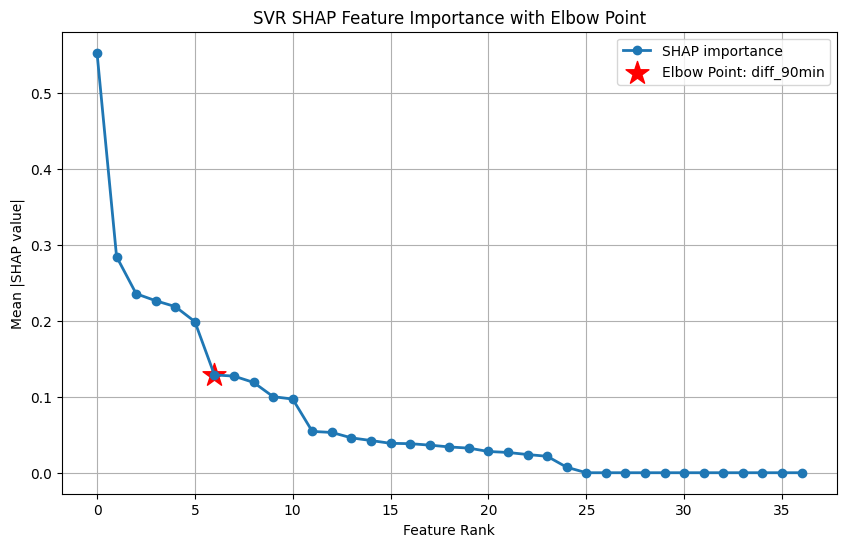

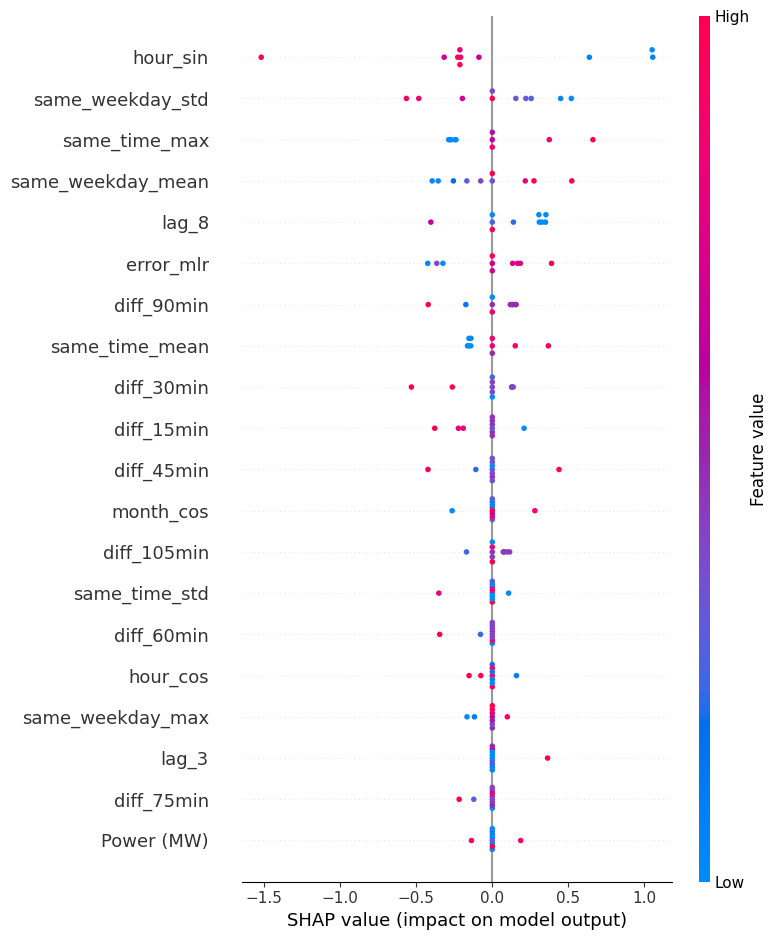

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
site : 5
--------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]


[SVR Feature Importance (SHAP)]
lag_8: 0.336202
hour_sin: 0.313130
Total solar irradiance (W/m2): 0.302237
same_weekday_std: 0.231362
same_weekday_mean: 0.212179
error_mlr: 0.113418
Atmosphere (hpa): 0.106657
diff_105min: 0.102979
same_time_std: 0.083937
Air temperature  (°C) : 0.074339
diff_75min: 0.056612
lag_3: 0.043850
lag_4: 0.043695
pred_mlr: 0.042957
lag_7: 0.036069
diff_15min: 0.033731
lag_1: 0.033337
hour_cos: 0.032481
lag_2: 0.030511
lag_6: 0.029103
diff_45min: 0.025232
overall_std: 0.016638
same_weekday_max: 0.015858
diff_90min: 0.013351
diff_60min: 0.013227
month_cos: 0.005747
Power (MW): 0.005422
same_time_max: 0.000000
same_time_min: 0.000000
overall_min: 0.000000
overall_max: 0.000000
same_weekday_min: 0.000000
overall_mean: 0.000000
same_time_mean: 0.000000
month_sin: 0.000000
lag_5: 0.000000
diff_30min: 0.000000


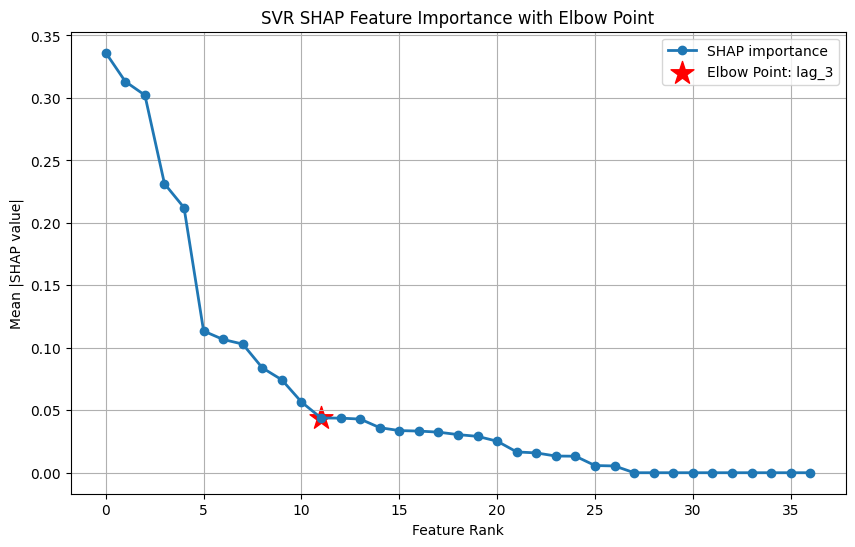

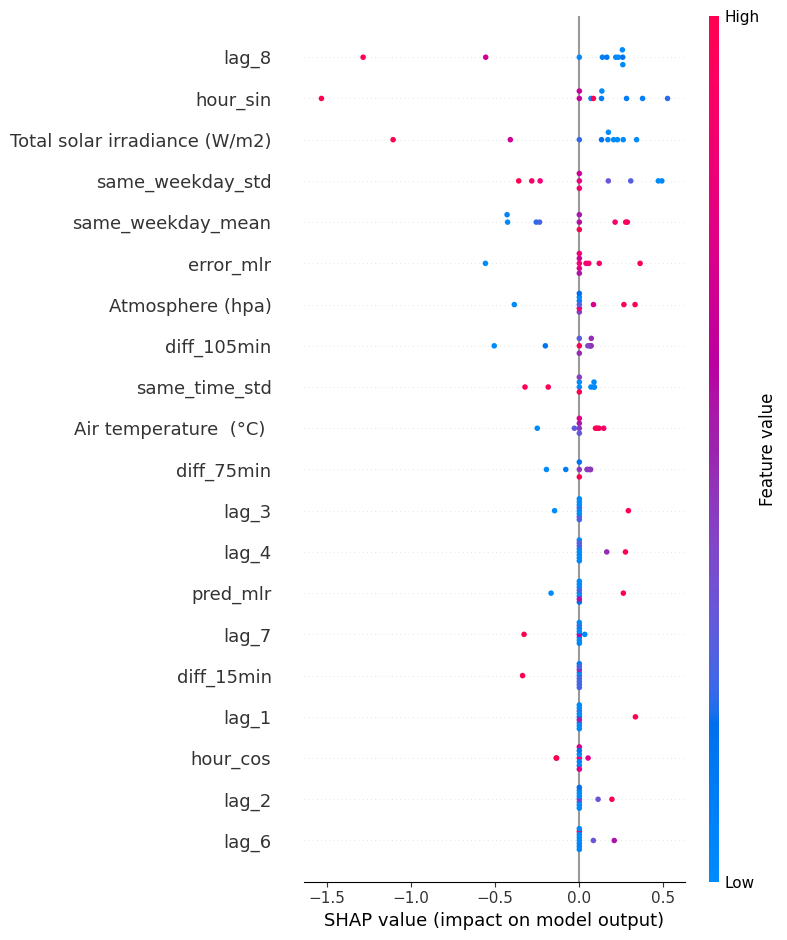

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
site : 6
--------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]


[SVR Feature Importance (SHAP)]
lag_8: 0.256842
same_time_mean: 0.203384
same_weekday_mean: 0.132701
same_time_max: 0.125852
same_weekday_std: 0.113007
error_mlr: 0.052279
overall_std: 0.041569
hour_sin: 0.040896
same_time_min: 0.035440
diff_105min: 0.026500
month_cos: 0.025439
overall_mean: 0.023565
diff_90min: 0.023415
month_sin: 0.018862
hour_cos: 0.018467
pred_mlr: 0.017893
lag_1: 0.016439
diff_60min: 0.015958
Atmosphere (hpa): 0.015546
lag_7: 0.014945
diff_45min: 0.012724
Power (MW): 0.009875
diff_15min: 0.009135
lag_4: 0.007044
lag_6: 0.006849
same_time_std: 0.006816
Air temperature  (°C) : 0.006503
same_weekday_max: 0.005401
diff_75min: 0.003473
Total solar irradiance (W/m2): 0.000000
overall_min: 0.000000
same_weekday_min: 0.000000
overall_max: 0.000000
lag_3: 0.000000
lag_2: 0.000000
lag_5: 0.000000
diff_30min: 0.000000


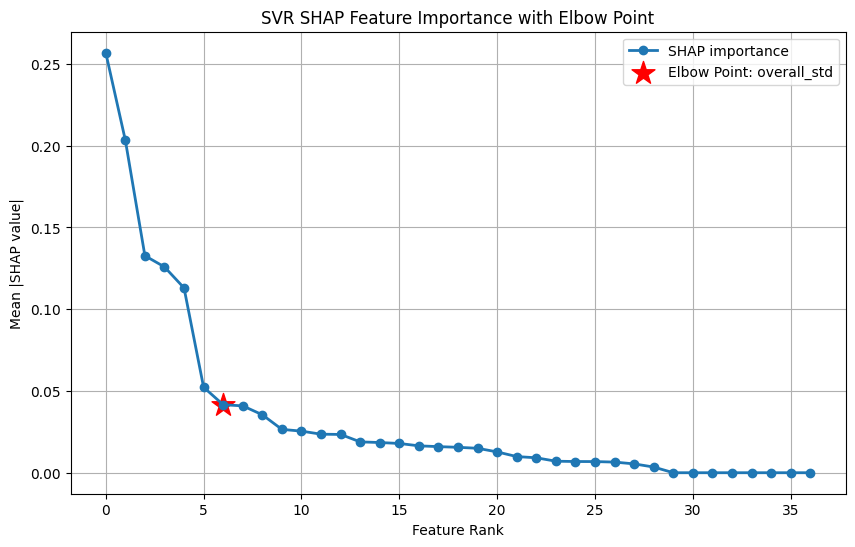

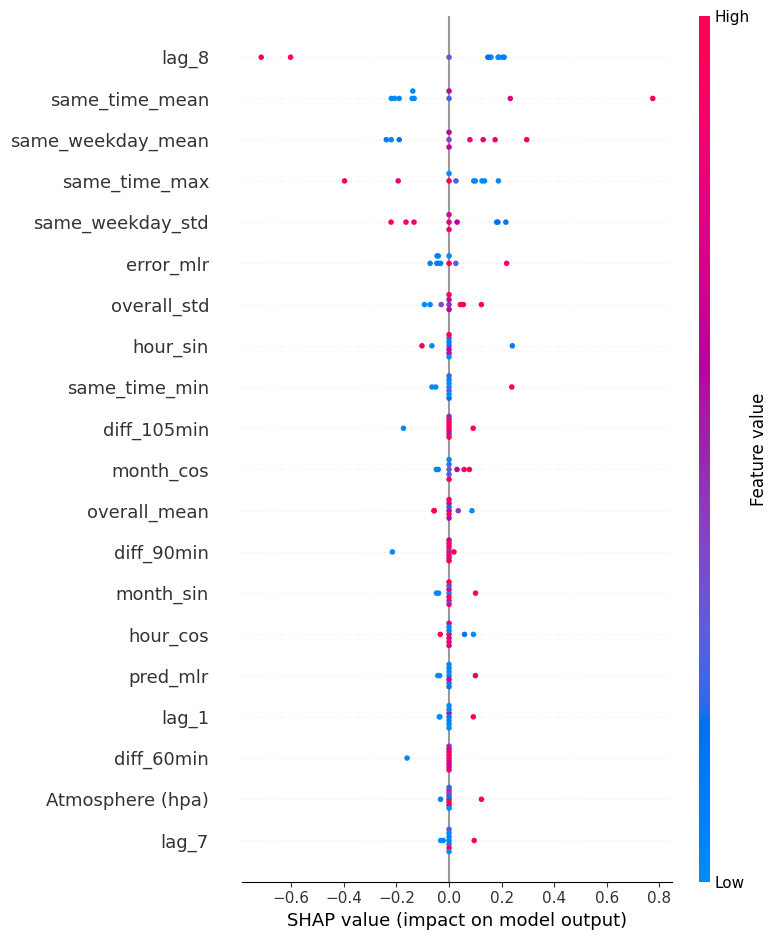

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
site : 7
--------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]


[SVR Feature Importance (SHAP)]
same_time_mean: 0.292904
Total solar irradiance (W/m2): 0.171505
error_mlr: 0.112419
same_weekday_mean: 0.093097
same_time_std: 0.081260
diff_15min: 0.070753
hour_sin: 0.066866
same_weekday_std: 0.061394
same_time_min: 0.061026
Air temperature  (°C) : 0.057815
lag_8: 0.053149
hour_cos: 0.038443
same_time_max: 0.035553
diff_105min: 0.015515
diff_45min: 0.012422
Atmosphere (hpa): 0.007043
month_cos: 0.006738
diff_90min: 0.005575
pred_mlr: 0.004158
diff_60min: 0.003851
overall_std: 0.003679
overall_max: 0.003348
Power (MW): 0.000000
lag_1: 0.000000
overall_min: 0.000000
same_weekday_max: 0.000000
month_sin: 0.000000
same_weekday_min: 0.000000
overall_mean: 0.000000
lag_6: 0.000000
lag_7: 0.000000
lag_4: 0.000000
lag_5: 0.000000
lag_3: 0.000000
lag_2: 0.000000
diff_75min: 0.000000
diff_30min: 0.000000


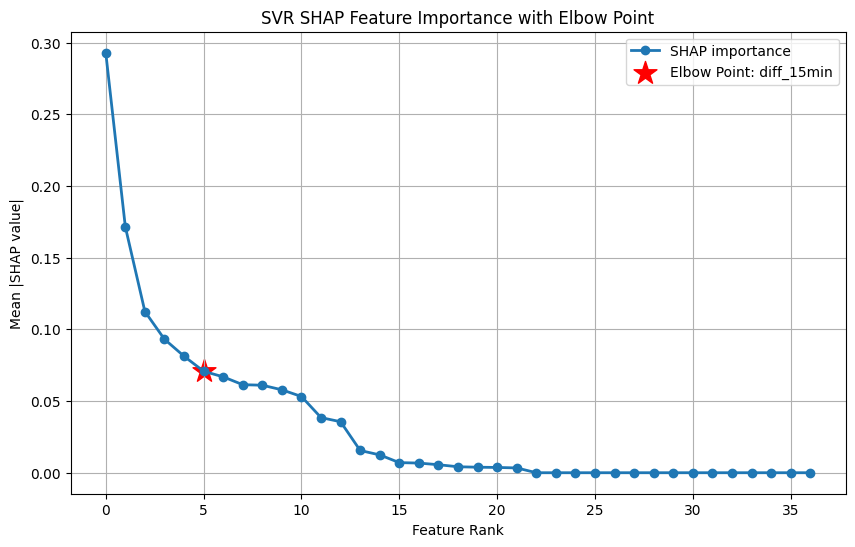

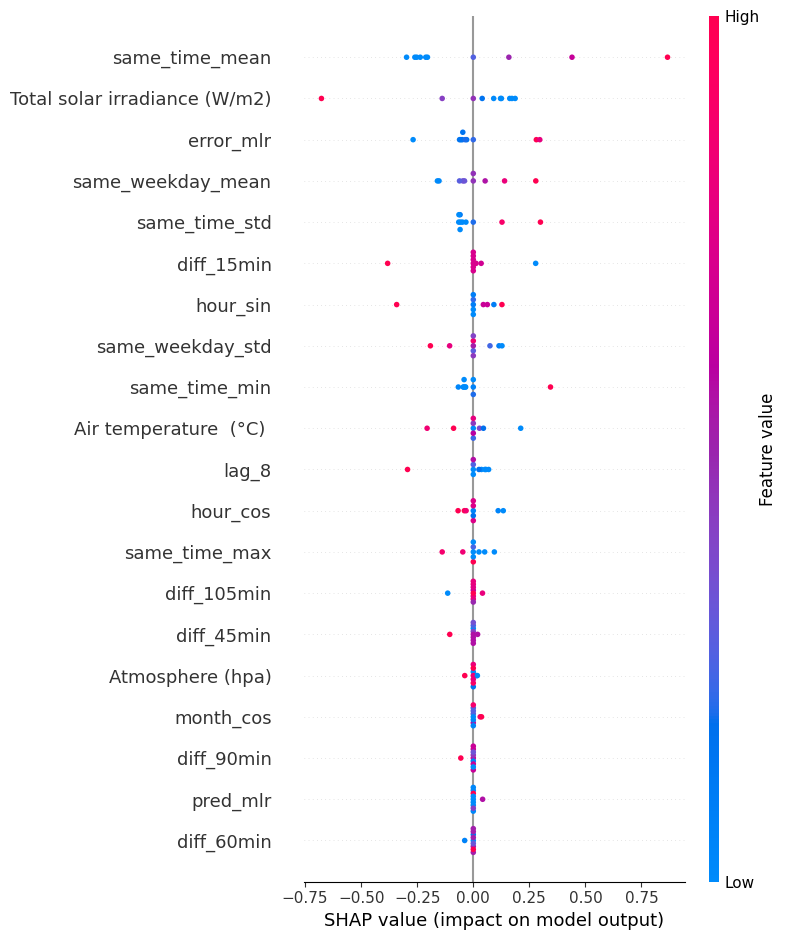

site : 8, best_forecast_model : lgb, forecast_model = mlr
forecast_model : SVR
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
site : 1
--------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]


[SVR Feature Importance (SHAP)]
Total solar irradiance (W/m2): 0.135088
error_svr: 0.113597
diff_15min: 0.081410
lag_8: 0.069629
same_time_max: 0.046116
hour_sin: 0.028836
hour_cos: 0.022836
diff_105min: 0.020865
diff_30min: 0.020150
same_time_mean: 0.019502
same_time_std: 0.014015
lag_1: 0.010170
lag_6: 0.008778
same_weekday_std: 0.008691
diff_45min: 0.008127
same_time_min: 0.007274
lag_7: 0.006779
pred_svr: 0.006183
month_cos: 0.005610
diff_90min: 0.004476
Air temperature  (°C) : 0.004311
lag_5: 0.002843
month_sin: 0.002588
diff_75min: 0.002580
diff_60min: 0.001878
lag_4: 0.001047
Atmosphere (hpa): 0.000000
Power (MW): 0.000000
same_weekday_mean: 0.000000
overall_min: 0.000000
overall_max: 0.000000
overall_std: 0.000000
overall_mean: 0.000000
same_weekday_max: 0.000000
same_weekday_min: 0.000000
lag_3: 0.000000
lag_2: 0.000000


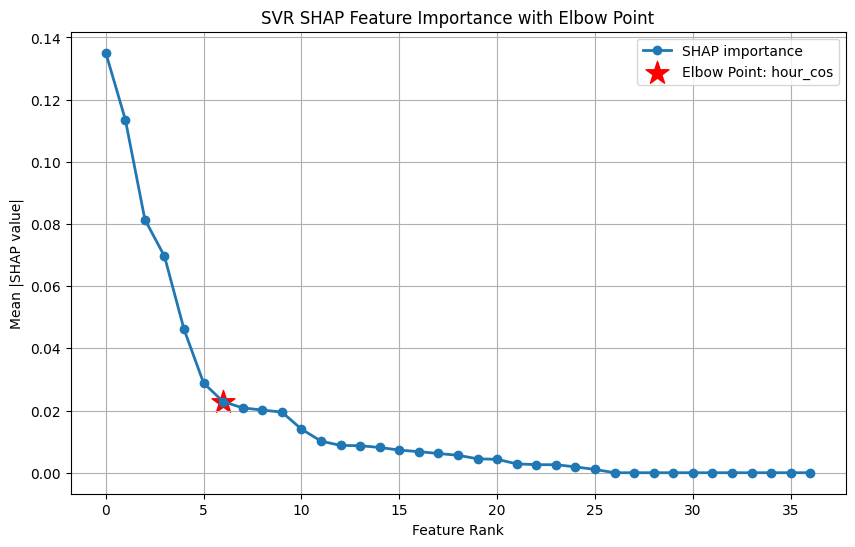

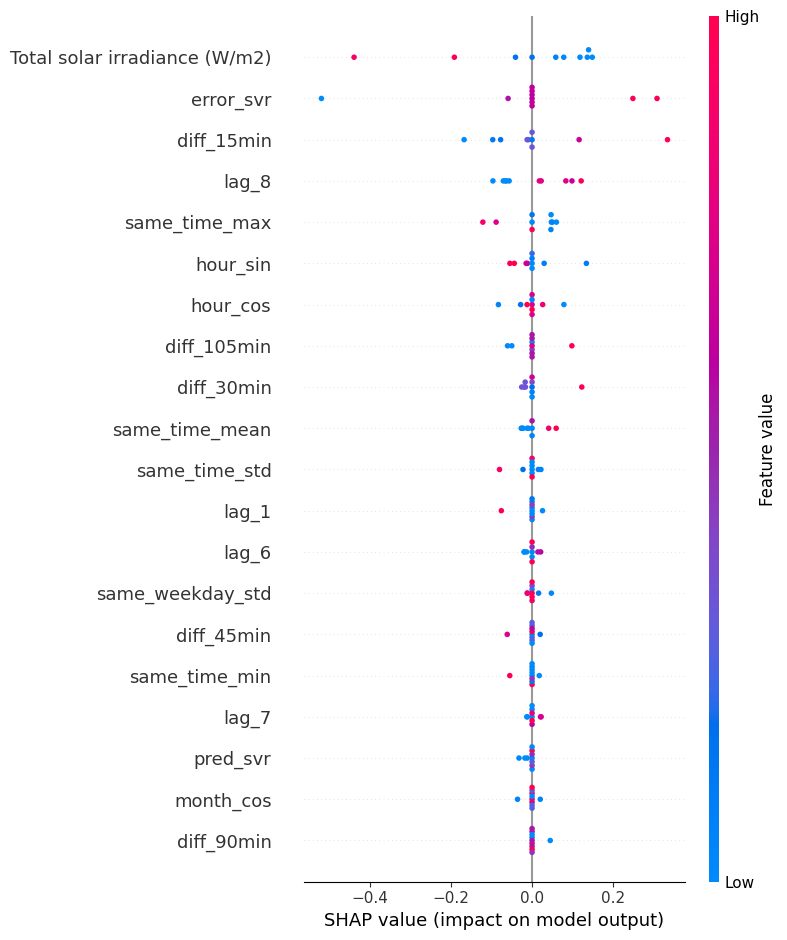

site : 2, best_forecast_model : lgb, forecast_model = svr
site : 4, best_forecast_model : mlr, forecast_model = svr
site : 5, best_forecast_model : mlr, forecast_model = svr
site : 6, best_forecast_model : mlr, forecast_model = svr
site : 7, best_forecast_model : mlr, forecast_model = svr
site : 8, best_forecast_model : lgb, forecast_model = svr
forecast_model : LGB
site : 1, best_forecast_model : svr, forecast_model = lgb
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
site : 2
--------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]


[SVR Feature Importance (SHAP)]
hour_cos: 0.194594
diff_15min: 0.090031
Total solar irradiance (W/m2): 0.089691
same_time_max: 0.087147
hour_sin: 0.065304
overall_mean: 0.047758
diff_30min: 0.046109
Air temperature  (°C) : 0.042710
overall_min: 0.035877
overall_max: 0.035219
diff_45min: 0.034422
lag_2: 0.027440
month_sin: 0.019147
same_weekday_max: 0.017532
same_time_min: 0.016291
diff_75min: 0.015981
lag_5: 0.015765
same_time_mean: 0.014852
Power (MW): 0.014695
pred_lgb: 0.012526
error_lgb: 0.010723
lag_8: 0.010366
month_cos: 0.010099
Atmosphere (hpa): 0.009349
lag_4: 0.003626
lag_3: 0.002916
same_weekday_mean: 0.000000
same_time_std: 0.000000
same_weekday_min: 0.000000
lag_1: 0.000000
overall_std: 0.000000
same_weekday_std: 0.000000
lag_7: 0.000000
lag_6: 0.000000
diff_60min: 0.000000
diff_105min: 0.000000
diff_90min: 0.000000


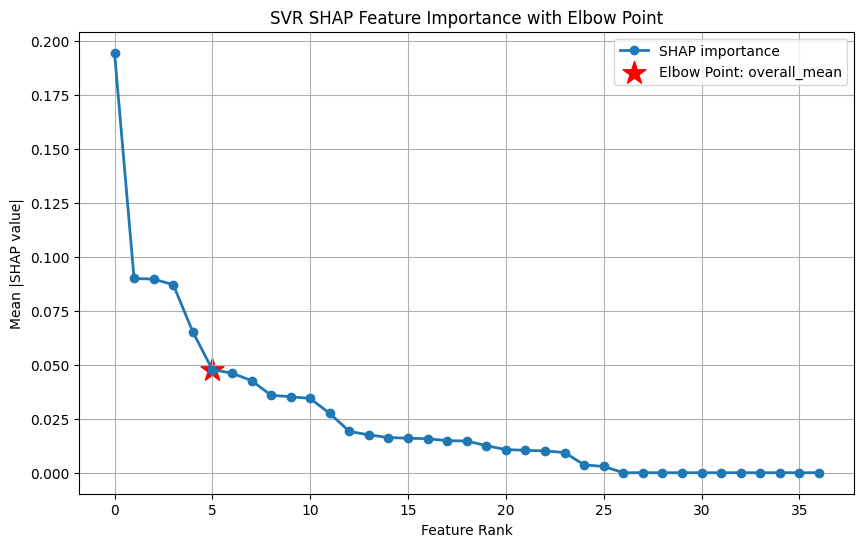

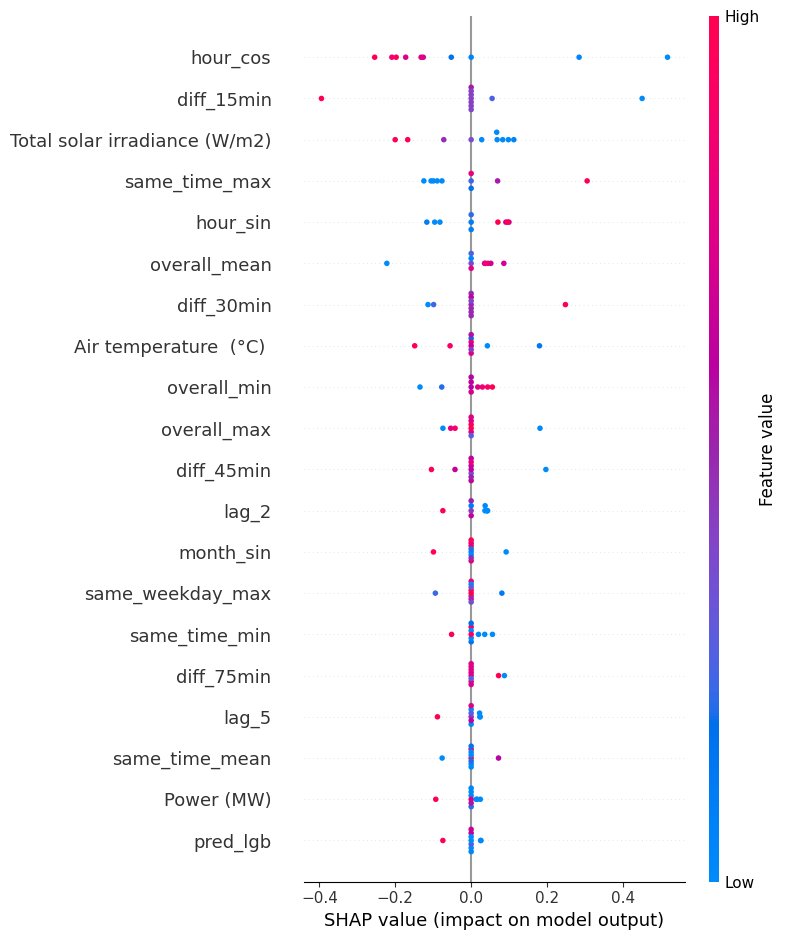

site : 4, best_forecast_model : mlr, forecast_model = lgb
site : 5, best_forecast_model : mlr, forecast_model = lgb
site : 6, best_forecast_model : mlr, forecast_model = lgb
site : 7, best_forecast_model : mlr, forecast_model = lgb
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
site : 8
--------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]


[SVR Feature Importance (SHAP)]
same_time_max: 0.031064
lag_8: 0.030980
same_time_std: 0.022426
same_time_mean: 0.022132
hour_sin: 0.021035
hour_cos: 0.018806
diff_15min: 0.018588
overall_std: 0.017398
error_lgb: 0.013301
diff_30min: 0.012905
diff_75min: 0.011839
diff_45min: 0.010081
diff_105min: 0.009971
lag_5: 0.008465
same_weekday_std: 0.007727
lag_1: 0.005730
overall_mean: 0.005018
same_weekday_max: 0.003252
lag_7: 0.003158
month_cos: 0.002800
lag_2: 0.002410
overall_max: 0.001326
Air temperature  (°C) : 0.001306
diff_90min: 0.001134
lag_4: 0.000959
month_sin: 0.000930
same_time_min: 0.000790
Atmosphere (hpa): 0.000753
lag_3: 0.000687
Power (MW): 0.000000
Total solar irradiance (W/m2): 0.000000
same_weekday_mean: 0.000000
same_weekday_min: 0.000000
overall_min: 0.000000
lag_6: 0.000000
diff_60min: 0.000000
pred_lgb: 0.000000


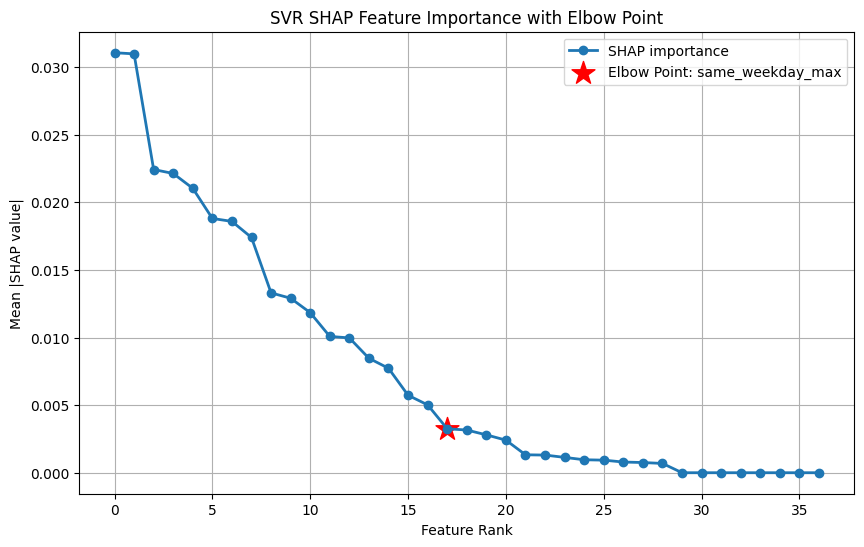

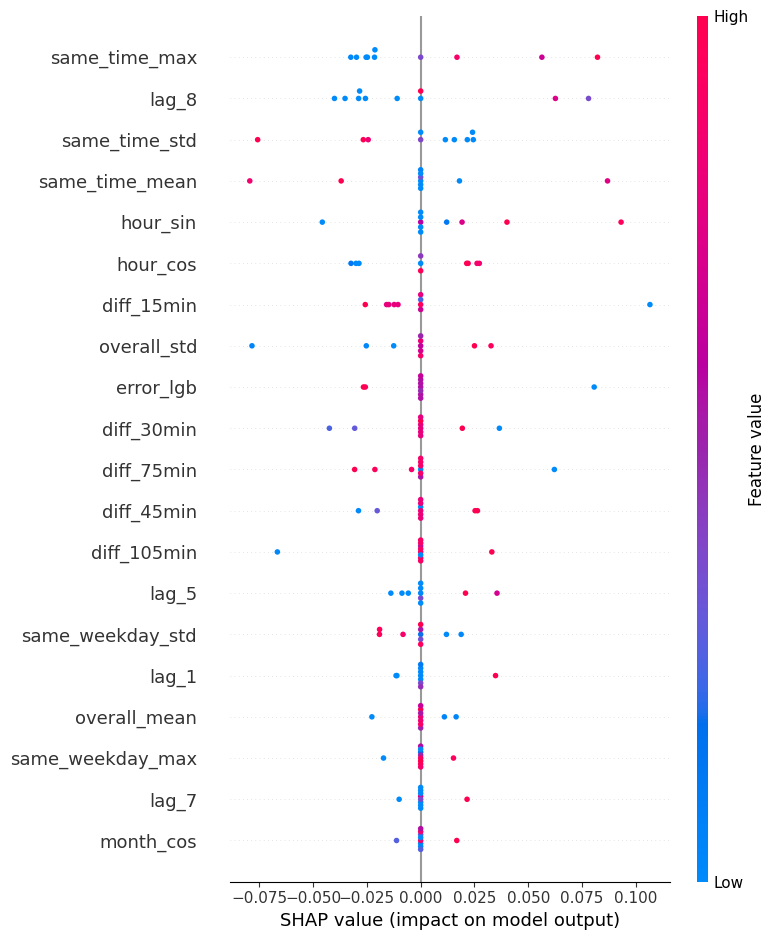

forecast_model : MLP
site : 1, best_forecast_model : svr, forecast_model = mlp
site : 2, best_forecast_model : lgb, forecast_model = mlp
site : 4, best_forecast_model : mlr, forecast_model = mlp
site : 5, best_forecast_model : mlr, forecast_model = mlp
site : 6, best_forecast_model : mlr, forecast_model = mlp
site : 7, best_forecast_model : mlr, forecast_model = mlp
site : 8, best_forecast_model : lgb, forecast_model = mlp


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
import multiprocessing



forecast_models = ['mlr','svr','lgb', 'mlp']
reforecast_models = ['mlr','svr','lgb', 'mlp']

mlr_files = sorted([os.path.join(path+'/result_of_paper/ann/', file) for file in os.listdir(path+'/result_of_paper/ann/') if file.endswith('.csv') and 'mlr' in file])
svr_files = sorted([os.path.join(path+'/result_of_paper/ann/', file) for file in os.listdir(path+'/result_of_paper/ann/') if file.endswith('.csv') and 'svr' in file])
lgb_files = sorted([os.path.join(path+'/result_of_paper/ann/', file) for file in os.listdir(path+'/result_of_paper/ann/') if file.endswith('.csv') and 'lgb' in file])
mlp_files = sorted([os.path.join(path+'/result_of_paper/ann/', file) for file in os.listdir(path+'/result_of_paper/ann/') if file.endswith('.csv') and 'mlp' in file])

mlr_df_list = []
svr_df_list = []
lgb_df_list = []
mlp_df_list = []

for file in mlr_files:
  mlr_df_list.append(pd.read_csv(file))
for file in svr_files:
  svr_df_list.append(pd.read_csv(file))
for file in lgb_files:
  lgb_df_list.append(pd.read_csv(file))
for file in mlp_files:
  mlp_df_list.append(pd.read_csv(file))

best_model_tuples = [
    ('svr', 'svr'),
    ('lgb', 'svr'),
    ('mlr', 'svr'),
    ('mlr', 'svr'),
    ('mlr', 'svr'),
    ('mlr', 'svr'),
    ('lgb', 'svr')
]
test_size = 2/24

df_lists=[mlr_df_list, svr_df_list,lgb_df_list, mlp_df_list]

for forecast_model, df_list in zip(forecast_models, df_lists):
  print('==============================================================================================')
  print(f'forecast_model : {forecast_model.upper()}')

  for df, site,(best_forecast_model, best_reforecast_model) in zip(df_list, [1,2,4,5,6,7,8], best_model_tuples):

    if best_forecast_model != forecast_model:
      print(f'site : {site}, best_forecast_model : {best_forecast_model}, forecast_model = {forecast_model}')
      continue

    print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    print(f'site : {site}')
    target = f'error_{forecast_model}'
    shifted_target = f'{target}_shifted'

    for reforecast_model in reforecast_models:
      if best_reforecast_model != reforecast_model:
        continue

      print('--------------------------------------------------------------------------------------------------------------------------------')

      df_copy = df.copy()
      df_copy[shifted_target] = df_copy[target].shift(-1)
      df_copy = df_copy.dropna().reset_index(drop=True)

      split_index = int(len(df_copy) * (1 - test_size))

      added_features = features.copy() + [f'error_{forecast_model}', f'pred_{forecast_model}']
      added_features = [col for col in added_features if col in df_copy.columns]
      X = df_copy[added_features]
      y = df_copy[shifted_target]
      X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
      y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

      scaler = StandardScaler()
      X_train_scaled = scaler.fit_transform(X_train)
      X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
      X_test_scaled = scaler.transform(X_test)
      X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

      reforecast_mlr = joblib.load(f"{path}/result_of_paper/ann/mlr_reforecasting_model_{forecast_model}_forecast_{str(site)}.joblib")
      reforecast_svr = joblib.load(f"{path}/result_of_paper/ann/svr_reforecasting_model_{forecast_model}_forecast_{str(site)}.joblib")
      reforecast_lgb_model = lgb.Booster(model_file=f"{path}/result_of_paper/ann/lgb_reforecasting_model_{forecast_model}_forecast_{str(site)}.txt")
      reforecast_mlp = joblib.load(f"{path}/result_of_paper/ann/mlp_reforecasting_model_{forecast_model}_forecast_{site}.joblib")


      if reforecast_model == 'mlr':
          # ------------------- MLR -------------------
          explainer_mlr = shap.Explainer(reforecast_mlr, X_test_scaled_df)
          shap_values_mlr = explainer_mlr(X_test_scaled_df)

          shap_importance = np.abs(shap_values_mlr.values).mean(axis=0)

          shap_df = pd.DataFrame({
              'feature': X_train.columns,
              'mean_abs_shap': shap_importance
          }).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

          print("\n[MLR Feature Importance (SHAP)]")
          for _, row in shap_df.iterrows():
            print(f"{row['feature']}: {row['mean_abs_shap']:.6f}")

          # elbow point
          x = np.arange(len(shap_df))
          y = shap_df['mean_abs_shap'].values
          x_scaled = MinMaxScaler().fit_transform(x.reshape(-1, 1)).flatten()
          y_scaled = MinMaxScaler().fit_transform(y.reshape(-1, 1)).flatten()

          start = np.array([x_scaled[0], y_scaled[0]])
          end = np.array([x_scaled[-1], y_scaled[-1]])

          line_vec = end - start
          line_vec_norm = line_vec / np.linalg.norm(line_vec)
          point_vecs = np.stack([x_scaled - start[0], y_scaled - start[1]], axis=1)
          projections = np.dot(point_vecs, line_vec_norm)
          projected_points = np.outer(projections, line_vec_norm) + start
          distances = np.linalg.norm(point_vecs - projected_points, axis=1)

          elbow_idx = np.argmax(distances)
          elbow_feature = shap_df.loc[elbow_idx, 'feature']
          elbow_value = shap_df.loc[elbow_idx, 'mean_abs_shap']

          plt.figure(figsize=(10, 6))
          plt.plot(x, y, marker='o', label='SHAP importance', linewidth=2)
          plt.scatter(elbow_idx, elbow_value, color='red', marker='*', s=300, label=f'Elbow Point: {elbow_feature}')
          plt.title("MLR SHAP Feature Importance with Elbow Point")
          plt.xlabel("Feature Rank")
          plt.ylabel("Mean |SHAP value|")
          plt.legend()
          plt.grid(True)
          plt.show()

          shap.summary_plot(shap_values_mlr, X_test_scaled_df, plot_type="dot", show=True)


      elif reforecast_model == 'svr':
        X_sample_df, y_sample = resample(X_train_scaled_df, y_train, n_samples=10, random_state=42)

        # X_sample_df = X_test_scaled_df.copy()

        # ▶ SHAP: 배경 데이터 (작게 유지)
        background = shap.utils.sample(X_sample_df, 10, random_state=42)

        # ▶ SHAP 계산 (KernelExplainer 사용)
        explainer = shap.KernelExplainer(reforecast_svr.predict, background)
        shap_values = explainer.shap_values(X_sample_df)

        # ▶ 평균 중요도 계산
        mean_abs_shap = np.abs(shap_values).mean(axis=0)
        shap_style_df = pd.DataFrame({
            'feature': X_sample_df.columns,
            'mean_abs_shap': mean_abs_shap
        }).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

        # ▶ 출력
        print("\n[SVR Feature Importance (SHAP)]")
        for _, row in shap_style_df.iterrows():
            print(f"{row['feature']}: {row['mean_abs_shap']:.6f}")

        # ▶ Elbow point 계산
        x = np.arange(len(shap_style_df))
        y = shap_style_df['mean_abs_shap'].values
        x_scaled = MinMaxScaler().fit_transform(x.reshape(-1, 1)).flatten()
        y_scaled = MinMaxScaler().fit_transform(y.reshape(-1, 1)).flatten()

        start = np.array([x_scaled[0], y_scaled[0]])
        end = np.array([x_scaled[-1], y_scaled[-1]])
        line_vec = end - start
        line_vec_norm = line_vec / np.linalg.norm(line_vec)
        point_vecs = np.stack([x_scaled - start[0], y_scaled - start[1]], axis=1)
        projections = np.dot(point_vecs, line_vec_norm)
        projected_points = np.outer(projections, line_vec_norm) + start
        distances = np.linalg.norm(point_vecs - projected_points, axis=1)

        elbow_idx = np.argmax(distances)
        elbow_feature = shap_style_df.loc[elbow_idx, 'feature']
        elbow_value = shap_style_df.loc[elbow_idx, 'mean_abs_shap']

        # ▶ 시각화
        plt.figure(figsize=(10, 6))
        plt.plot(x, y, marker='o', label='SHAP importance', linewidth=2)
        plt.scatter(elbow_idx, elbow_value, color='red', marker='*', s=300, label=f'Elbow Point: {elbow_feature}')
        plt.title("SVR SHAP Feature Importance with Elbow Point")
        plt.xlabel("Feature Rank")
        plt.ylabel("Mean |SHAP value|")
        plt.legend()
        plt.grid(True)
        plt.show()

        # ▶ SHAP Summary Plot
        shap.summary_plot(shap_values, X_sample_df, plot_type="dot", show=True)


      elif reforecast_model == 'lgb':
      # ------------------- LGB -------------------explainer_lgb = shap.Explainer(reforecast_lgb_model)

        explainer_lgb = shap.Explainer(reforecast_lgb_model)
        shap_values_lgb = explainer_lgb(X_test)

        shap_importance = np.abs(shap_values_lgb.values).mean(axis=0)

        # DataFrame으로 정리
        shap_df = pd.DataFrame({
            'feature': X_test.columns,
            'mean_abs_shap': shap_importance
        }).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

        # 출력
        print("\n[LGB Feature Importance (SHAP)]")
        for _, row in shap_df.iterrows():
            print(f"{row['feature']}: {row['mean_abs_shap']:.6f}")

        # kneedle 알고리즘 사용
        x = np.arange(len(shap_df))
        y = shap_df['mean_abs_shap'].values
        x_scaled = MinMaxScaler().fit_transform(x.reshape(-1, 1)).flatten()
        y_scaled = MinMaxScaler().fit_transform(y.reshape(-1, 1)).flatten()

        # 직선 시작점과 끝점
        start = np.array([x_scaled[0], y_scaled[0]])
        end = np.array([x_scaled[-1], y_scaled[-1]])

        # 각 점에서 직선까지의 수직 거리 계산
        line_vec = end - start
        line_vec_norm = line_vec / np.linalg.norm(line_vec)
        point_vecs = np.stack([x_scaled - start[0], y_scaled - start[1]], axis=1)
        projections = np.dot(point_vecs, line_vec_norm)
        projected_points = np.outer(projections, line_vec_norm) + start
        distances = np.linalg.norm(point_vecs - projected_points, axis=1)

        # 가장 멀리 떨어진 점이 elbow point
        elbow_idx = np.argmax(distances)
        elbow_feature = shap_df.loc[elbow_idx, 'feature']
        elbow_value = shap_df.loc[elbow_idx, 'mean_abs_shap']

        # 시각화
        plt.figure(figsize=(10, 6))
        plt.plot(x, y, marker='o', label='SHAP importance', linewidth=2)
        plt.scatter(elbow_idx, elbow_value, color='red', marker='*', s=300, label=f'Elbow Point: {elbow_feature}')
        plt.title("SHAP Feature Importance with Elbow Point (Distance Method)")
        plt.xlabel("Feature Rank")
        plt.ylabel("Mean |SHAP value|")
        plt.legend()
        plt.grid(True)
        plt.show()

        shap.summary_plot(shap_values_lgb, X_test, plot_type="dot", show=True)


      elif reforecast_model == 'mlp':
        # ------------------- MLP -------------------
        def compute_shap_partial(batch):
            explainer = shap.KernelExplainer(reforecast_mlp.predict, background)
            return explainer.shap_values(batch)

        X_target = shap.utils.sample(X_test_scaled_df, 2000, random_state=42)
        background = shap.utils.sample(X_target, 100, random_state=42)
        X_batches = np.array_split(X_target, 8)
        with multiprocessing.Pool(processes=8) as pool:
            shap_parts = pool.map(compute_shap_partial, X_batches)
        shap_values = np.concatenate(shap_parts, axis=0)

        shap_importance = np.abs(shap_values).mean(axis=0)
        shap_df = pd.DataFrame({
            'feature': X_train_scaled_df.columns,
            'mean_abs_shap': shap_importance
        }).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

        print("\n[MLP Feature Importance (SHAP)]")
        for _, row in shap_df.iterrows():
            print(f"{row['feature']}: {row['mean_abs_shap']:.6f}")

        # elbow point 계산 및 시각화
        x = np.arange(len(shap_df))
        y = shap_df['mean_abs_shap'].values
        x_scaled = MinMaxScaler().fit_transform(x.reshape(-1, 1)).flatten()
        y_scaled = MinMaxScaler().fit_transform(y.reshape(-1, 1)).flatten()
        start = np.array([x_scaled[0], y_scaled[0]])
        end = np.array([x_scaled[-1], y_scaled[-1]])
        line_vec = end - start
        line_vec_norm = line_vec / np.linalg.norm(line_vec)
        point_vecs = np.stack([x_scaled - start[0], y_scaled - start[1]], axis=1)
        projections = np.dot(point_vecs, line_vec_norm)
        projected_points = np.outer(projections, line_vec_norm) + start
        distances = np.linalg.norm(point_vecs - projected_points, axis=1)
        elbow_idx = np.argmax(distances)
        elbow_feature = shap_df.loc[elbow_idx, 'feature']
        elbow_value = shap_df.loc[elbow_idx, 'mean_abs_shap']

        plt.figure(figsize=(10, 6))
        plt.plot(x, y, marker='o', label='SHAP importance', linewidth=2)
        plt.scatter(elbow_idx, elbow_value, color='red', marker='*', s=300, label=f'Elbow Point: {elbow_feature}')
        plt.title("MLP SHAP Feature Importance with Elbow Point")
        plt.xlabel("Feature Rank")
        plt.ylabel("Mean |SHAP value|")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        shap.summary_plot(shap_values, X_target, plot_type="dot", show=True)



## Forecast test

In [ ]:
from sklearn.preprocessing import MinMaxScaler


for i, df_index in enumerate(a):
  print('----------------------------------------------------------------------------------')
  for forecast_model in ['mlr','svr','lgb','mlp']:
    start_str, end_str = operation_hours_array[i]
    file = [os.path.join(path + '/lag_added_dataset/', file)
            for file in os.listdir(path + '/lag_added_dataset/')
            if file.endswith('.csv') and f'{str(df_index)}' in file and 'feature_added_dataset_Solar' in file][0]
    print(file)
    df = pd.read_csv(file)

    target = 'Power (MW)'
    shifted_target = 'Power_shifted'
    df[shifted_target] = df[target].shift(-1)
    df = df.dropna().reset_index(drop=True)

    split_index = int(len(df) * (1 - test_size))

    added_features = [col for col in features if col in df.columns]
    X = df[added_features]
    y = df[shifted_target]
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)


    if forecast_model == 'mlr':
      model = joblib.load(f"{path}/result_of_paper/ann/mlr_forecasting_model_{df_index}.joblib")
      explainer = shap.Explainer(model, X_train_scaled_df)
      shap_values = explainer(X_test_scaled_df)

      importance_df = pd.DataFrame({
        'feature': X_test_scaled_df.columns,
        'mean_abs_shap': np.abs(shap_values.values).mean(axis=0)
      }).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

    elif forecast_model == 'svr':
      model = joblib.load(f"{path}/result_of_paper/ann/svr_forecasting_model_{df_index}.joblib")

      X_sample_df, y_sample = resample(X_train_scaled_df, y_train, n_samples=5000, random_state=42)
      importance_dict = permutation_importance_per_instance(
          columns=X_sample_df.columns,
          model=model,
          X=X_sample_df,
          n_repeats=5,
          n_jobs=-1
      )

      importance_df = pd.DataFrame({
          'feature': X_sample_df.columns,
          'mean_abs_shap': [np.mean(np.abs(v)) for v in importance_dict.values()]
      }).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

    elif forecast_model == 'lgb':
      model = lgb.Booster(model_file=f"{path}/result_of_paper/ann/lgb_forecasting_model_{df_index}.txt")
      explainer = shap.Explainer(model)
      shap_values = explainer(X_test)
      importance_df = pd.DataFrame({
          'feature': X_test.columns,
          'mean_abs_shap': np.abs(shap_values.values).mean(axis=0)
      }).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

    elif forecast_model == 'mlp':
      model = joblib.load(f"{path}/result_of_paper/ann/mlp_forecasting_model_{df_index}.joblib")
      X_sample_df, y_sample = resample(X_train_scaled_df, y_train, n_samples=5000, random_state=42)
      importance_dict = permutation_importance_per_instance(
          columns=X_sample_df.columns,
          model=model,
          X=X_sample_df,
          n_repeats=5,
          n_jobs=-1
      )
      importance_df = pd.DataFrame({
          'feature': X_sample_df.columns,
          'mean_abs_shap': [np.mean(np.abs(v)) for v in importance_dict.values()]
      }).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

    if forecast_model in ['mlr', 'svr', 'lgb', 'mlp']:
      print(f"\n[{forecast_model.upper()} Feature Importance]")
      for _, row in importance_df.iterrows():
        print(f"{row['feature']}: {row['mean_abs_shap']:.6f}")

      # Elbow point 계산
      x = np.arange(len(importance_df))
      y = importance_df['mean_abs_shap'].values
      x_scaled = MinMaxScaler().fit_transform(x.reshape(-1, 1)).flatten()
      y_scaled = MinMaxScaler().fit_transform(y.reshape(-1, 1)).flatten()

      start = np.array([x_scaled[0], y_scaled[0]])
      end = np.array([x_scaled[-1], y_scaled[-1]])
      line_vec = end - start
      line_vec_norm = line_vec / np.linalg.norm(line_vec)
      point_vecs = np.stack([x_scaled - start[0], y_scaled - start[1]], axis=1)
      projections = np.dot(point_vecs, line_vec_norm)
      projected_points = np.outer(projections, line_vec_norm) + start
      distances = np.linalg.norm(point_vecs - projected_points, axis=1)

      elbow_idx = np.argmax(distances)
      elbow_feature = importance_df.loc[elbow_idx, 'feature']
      elbow_value = importance_df.loc[elbow_idx, 'mean_abs_shap']

      # 시각화
      plt.figure(figsize=(10, 6))
      plt.plot(x, y, marker='o', label='SHAP importance', linewidth=2)
      plt.scatter(elbow_idx, elbow_value, color='red', marker='*', s=300, label=f'Elbow Point: {elbow_feature}')
      plt.title(f"{forecast_model.upper()} SHAP Feature Importance")
      plt.xlabel("Feature Rank")
      plt.ylabel("Mean |SHAP value|")
      plt.legend()
      plt.grid(True)
      plt.show()


## Forecast train

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
site : 1
--------------------------------------------------------------------------------------------------------------------------------
forecast_model : mlr

[MLR Feature Importance (SHAP)]
Power (MW): 1.636573
lag_2: 1.584811
lag_1: 1.555193
lag_3: 1.431223
lag_4: 1.358237
lag_5: 1.281232
lag_6: 1.240087
lag_7: 1.119614
lag_8: 0.570017
diff_105min: 0.567716
diff_75min: 0.532616
diff_90min: 0.484980
Total solar irradiance (W/m2): 0.479716
hour_cos: 0.463359
diff_60min: 0.458446
diff_45min: 0.382627
same_time_mean: 0.344427
diff_15min: 0.269379
same_weekday_mean: 0.245827
same_time_max: 0.165422
same_time_std: 0.161868
same_weekday_std: 0.150039
diff_30min: 0.103712
same_time_min: 0.094219
Atmosphere (hpa): 0.085885
hour_sin: 0.065273
month_cos: 0.022931
overall_mean: 0.022184
Air temperature  (°C) : 0.015389
overall_std: 0.010697
overall_max: 0.010574
same_weekday_max: 0

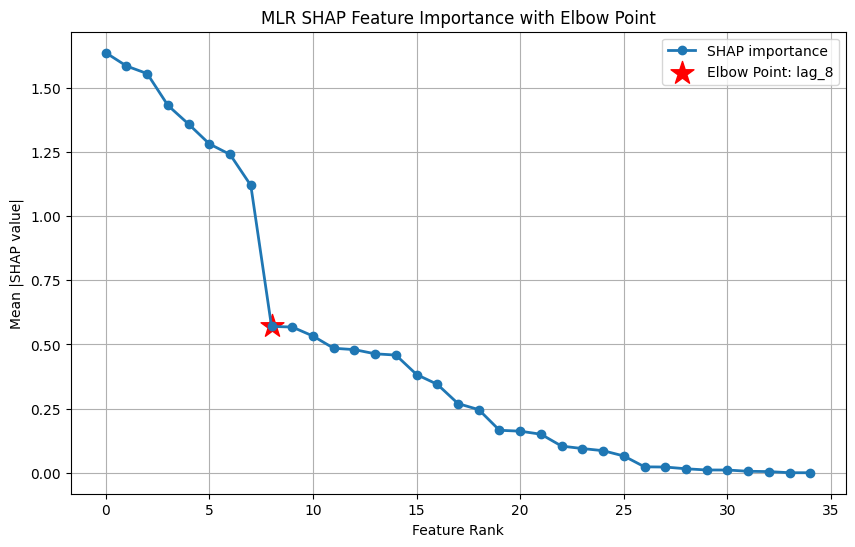

--------------------------------------------------------------------------------------------------------------------------------
forecast_model : svr
Power (MW): 2.065321
lag_2: 1.953636
lag_1: 1.895897
lag_3: 1.800840
lag_4: 1.714377
lag_5: 1.588043
Total solar irradiance (W/m2): 1.538945
lag_6: 1.505579
lag_7: 1.326981
diff_105min: 1.071703
diff_90min: 0.953242
diff_75min: 0.915369
same_time_max: 0.903516
diff_15min: 0.838441
diff_60min: 0.794626
same_time_mean: 0.782706
diff_45min: 0.712458
hour_cos: 0.687232
lag_8: 0.670052
same_time_std: 0.637160
same_time_min: 0.536712
same_weekday_std: 0.526213
diff_30min: 0.508267
overall_mean: 0.454709
same_weekday_mean: 0.447051
hour_sin: 0.438660
Air temperature  (°C) : 0.430921
overall_std: 0.383776
month_cos: 0.367661
same_weekday_max: 0.348260
month_sin: 0.330422
Atmosphere (hpa): 0.198549
overall_max: 0.168060
same_weekday_min: 0.000000
overall_min: 0.000000


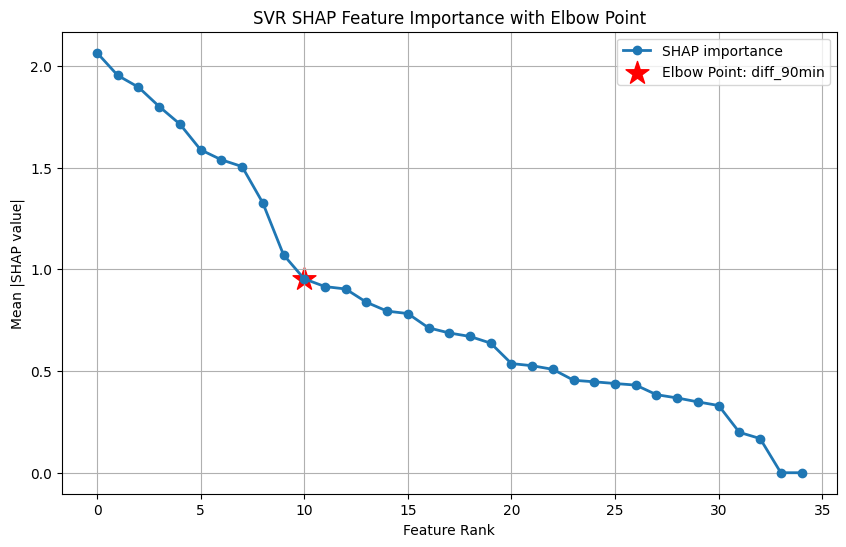

--------------------------------------------------------------------------------------------------------------------------------
forecast_model : lgb

[LGB Feature Importance (SHAP)]
Power (MW): 10.615706
Total solar irradiance (W/m2): 0.453629
hour_sin: 0.319818
diff_15min: 0.279046
diff_105min: 0.173585
same_time_mean: 0.130745
lag_2: 0.119420
diff_75min: 0.110763
hour_cos: 0.103521
same_time_max: 0.103185
lag_1: 0.088984
lag_3: 0.061623
lag_6: 0.056718
lag_4: 0.048777
Atmosphere (hpa): 0.046402
diff_90min: 0.044152
diff_60min: 0.043938
diff_45min: 0.040591
lag_7: 0.040503
diff_30min: 0.038544
lag_5: 0.037337
Air temperature  (°C) : 0.030835
month_cos: 0.030085
overall_mean: 0.026754
lag_8: 0.024909
same_time_std: 0.015803
same_weekday_std: 0.011070
overall_max: 0.010993
same_weekday_mean: 0.010626
same_weekday_max: 0.009171
overall_std: 0.008802
same_time_min: 0.008697
month_sin: 0.002393
same_weekday_min: 0.000000
overall_min: 0.000000


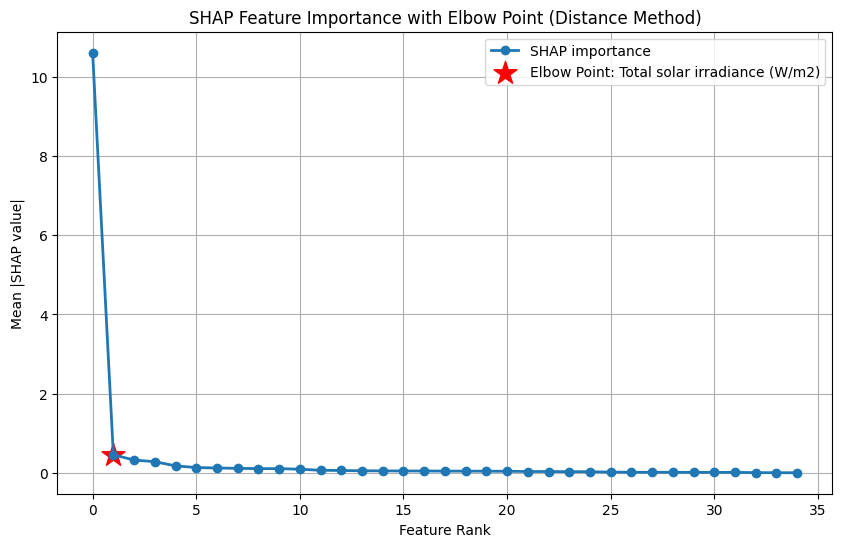

--------------------------------------------------------------------------------------------------------------------------------
forecast_model : mlp


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)



[MLP Feature Importance (SHAP)]
Total solar irradiance (W/m2): 1.515561
lag_4: 1.246515
lag_2: 1.246016
lag_5: 1.240202
hour_cos: 1.194336
lag_3: 1.009688
lag_6: 0.996689
Power (MW): 0.957746
same_time_max: 0.838236
lag_7: 0.593097
diff_75min: 0.431377
lag_1: 0.428988
diff_90min: 0.319685
diff_15min: 0.214885
diff_45min: 0.136439
diff_60min: 0.126287
diff_105min: 0.100878
overall_mean: 0.031702
same_time_min: 0.020854
hour_sin: 0.018309
same_time_std: 0.016251
Air temperature  (°C) : 0.011974
overall_std: 0.009772
diff_30min: 0.006094
same_weekday_std: 0.004300
lag_8: 0.003021
same_time_mean: 0.001993
same_weekday_max: 0.001695
month_cos: 0.000590
Atmosphere (hpa): 0.000383
overall_max: 0.000333
month_sin: 0.000232
same_weekday_mean: 0.000000
same_weekday_min: 0.000000
overall_min: 0.000000


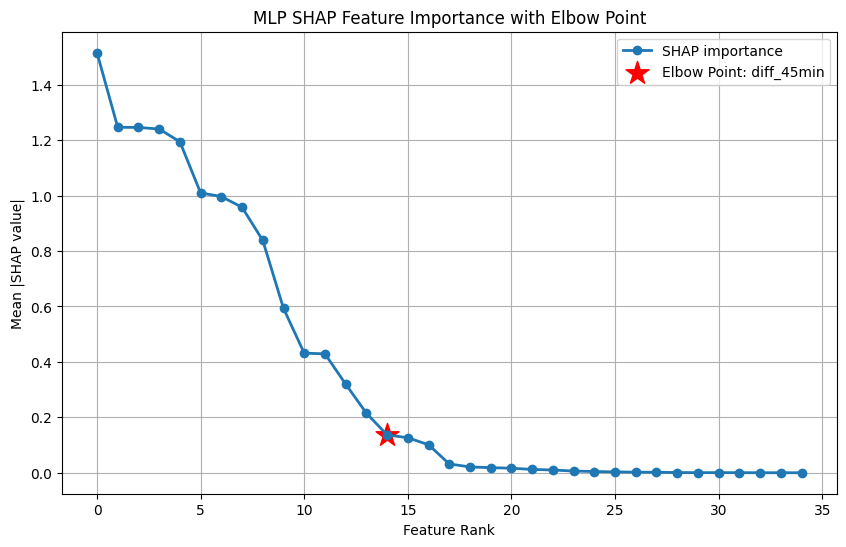

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
site : 2
--------------------------------------------------------------------------------------------------------------------------------
forecast_model : mlr

[MLR Feature Importance (SHAP)]
Power (MW): 3.483175
lag_2: 3.364120
lag_1: 3.332470
lag_4: 2.949136
lag_3: 2.932293
lag_5: 2.547328
lag_6: 2.525771
lag_7: 2.192662
same_time_mean: 1.323041
diff_105min: 1.249486
diff_75min: 1.123293
hour_cos: 1.028585
diff_90min: 1.013386
diff_45min: 0.932365
diff_60min: 0.725969
lag_8: 0.678142
diff_15min: 0.468431
Air temperature  (°C) : 0.356044
same_weekday_mean: 0.333242
diff_30min: 0.305114
same_time_max: 0.284261
overall_mean: 0.273290
Atmosphere (hpa): 0.222017
overall_std: 0.200200
same_weekday_std: 0.119551
month_sin: 0.106320
Total solar irradiance (W/m2): 0.093126
same_time_min: 0.037256
same_weekday_min: 0.036402
same_time_std: 0.024491
overall_max: 0.020596
overall_min

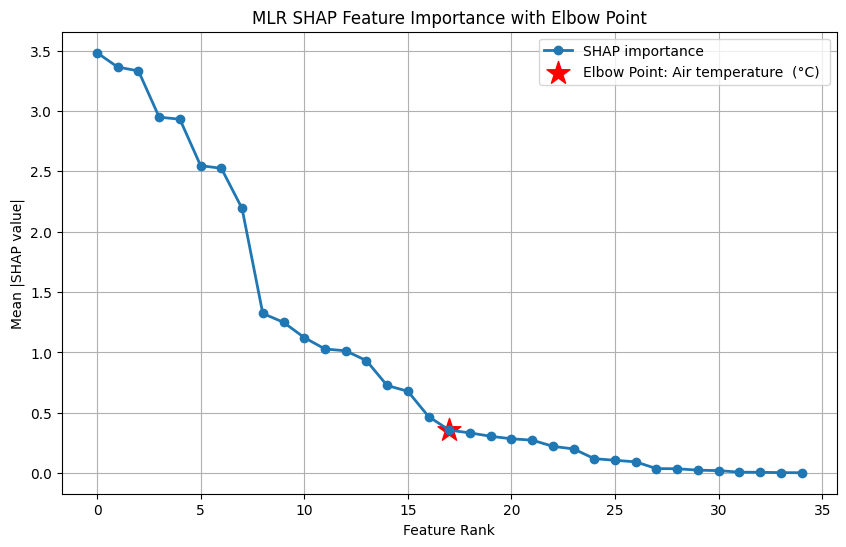

--------------------------------------------------------------------------------------------------------------------------------
forecast_model : svr
Power (MW): 4.158627
lag_2: 3.841180
lag_1: 3.788739
lag_3: 3.592624
lag_4: 3.460020
lag_5: 3.223082
lag_6: 3.054480
lag_7: 2.626191
diff_105min: 2.163661
diff_90min: 1.860430
diff_75min: 1.827867
diff_15min: 1.752629
diff_60min: 1.601429
diff_45min: 1.540593
hour_cos: 1.522167
Total solar irradiance (W/m2): 1.519923
same_time_mean: 1.477779
same_time_max: 1.418158
lag_8: 1.340946
same_time_std: 1.163388
diff_30min: 1.132295
same_time_min: 1.043343
same_weekday_std: 0.984752
hour_sin: 0.841767
overall_mean: 0.824581
overall_std: 0.810357
same_weekday_mean: 0.773855
Air temperature  (°C) : 0.765130
month_cos: 0.722952
same_weekday_max: 0.680903
month_sin: 0.640825
overall_max: 0.435500
Atmosphere (hpa): 0.309960
overall_min: 0.305029
same_weekday_min: 0.257256


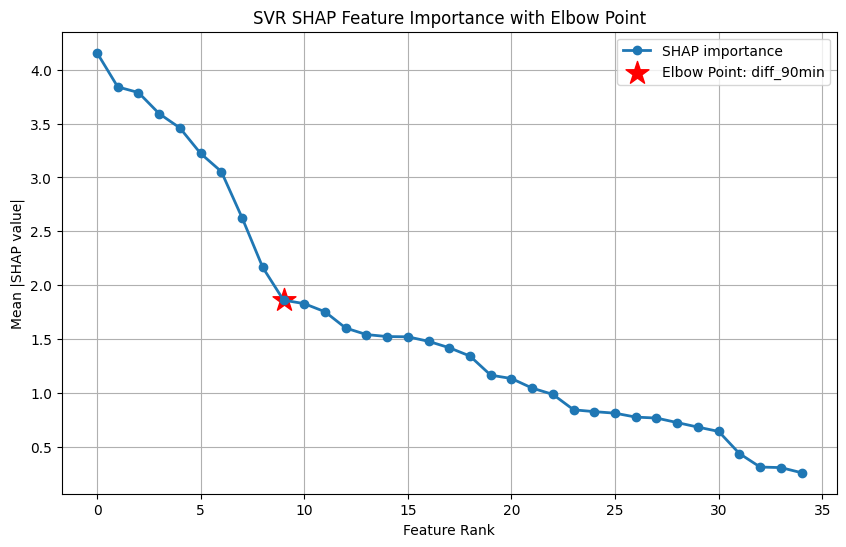

--------------------------------------------------------------------------------------------------------------------------------
forecast_model : lgb

[LGB Feature Importance (SHAP)]
Power (MW): 22.181988
hour_sin: 0.580803
hour_cos: 0.524115
diff_105min: 0.487579
diff_15min: 0.457748
same_time_mean: 0.347669
lag_1: 0.228710
same_time_max: 0.209022
Total solar irradiance (W/m2): 0.128526
diff_30min: 0.114744
lag_2: 0.106435
diff_45min: 0.103173
diff_90min: 0.088574
diff_75min: 0.087063
diff_60min: 0.087062
Air temperature  (°C) : 0.071688
overall_std: 0.057639
lag_4: 0.049161
lag_3: 0.045192
same_weekday_std: 0.044866
month_cos: 0.043297
lag_8: 0.041621
overall_max: 0.036276
Atmosphere (hpa): 0.032158
lag_5: 0.031991
lag_6: 0.029605
same_time_min: 0.029262
lag_7: 0.029004
overall_mean: 0.027428
same_weekday_mean: 0.025302
same_weekday_max: 0.020112
overall_min: 0.019619
same_time_std: 0.019613
same_weekday_min: 0.011602
month_sin: 0.006881


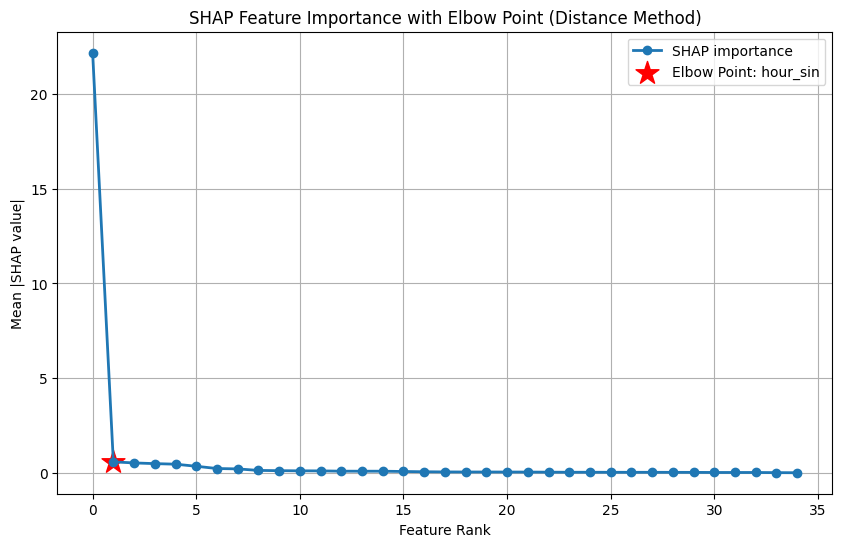

--------------------------------------------------------------------------------------------------------------------------------
forecast_model : mlp


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)



[MLP Feature Importance (SHAP)]
hour_cos: 3.224454
lag_4: 2.720471
lag_6: 2.597580
lag_3: 2.444872
lag_2: 2.426631
Power (MW): 2.341226
lag_1: 2.260606
lag_5: 2.033270
lag_7: 1.393943
diff_75min: 1.320335
diff_105min: 0.865751
same_time_mean: 0.755208
diff_90min: 0.329448
diff_45min: 0.300815
diff_15min: 0.298229
diff_60min: 0.243032
diff_30min: 0.208935
Air temperature  (°C) : 0.103221
hour_sin: 0.028996
lag_8: 0.027421
same_time_max: 0.021825
Total solar irradiance (W/m2): 0.018856
month_cos: 0.007481
same_time_std: 0.007287
overall_mean: 0.004699
same_weekday_std: 0.004248
same_weekday_mean: 0.002602
same_time_min: 0.002327
overall_std: 0.001510
overall_max: 0.001182
Atmosphere (hpa): 0.001160
month_sin: 0.000833
same_weekday_min: 0.000496
same_weekday_max: 0.000458
overall_min: 0.000000


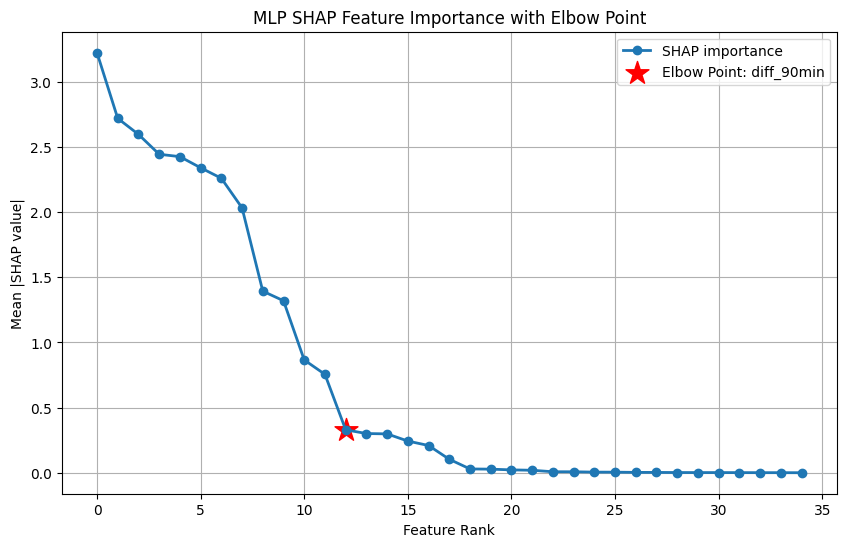

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
site : 4
--------------------------------------------------------------------------------------------------------------------------------
forecast_model : mlr

[MLR Feature Importance (SHAP)]
Power (MW): 3.194454
lag_1: 3.179002
lag_2: 3.033842
lag_3: 2.803039
lag_4: 2.625376
lag_5: 2.554431
lag_6: 2.261445
lag_7: 2.131391
lag_8: 1.472792
same_weekday_std: 1.177797
diff_105min: 1.175270
diff_90min: 1.139718
same_weekday_mean: 1.099714
diff_60min: 0.865821
diff_75min: 0.865555
hour_cos: 0.714677
diff_45min: 0.665078
hour_sin: 0.629542
same_time_max: 0.610735
same_time_mean: 0.482139
same_time_std: 0.414411
diff_30min: 0.274049
same_weekday_max: 0.231578
Total solar irradiance (W/m2): 0.100445
overall_max: 0.077881
same_time_min: 0.073664
Air temperature  (°C) : 0.053442
diff_15min: 0.040621
overall_std: 0.039404
overall_mean: 0.038302
overall_min: 0.016897
month_sin: 0.0152

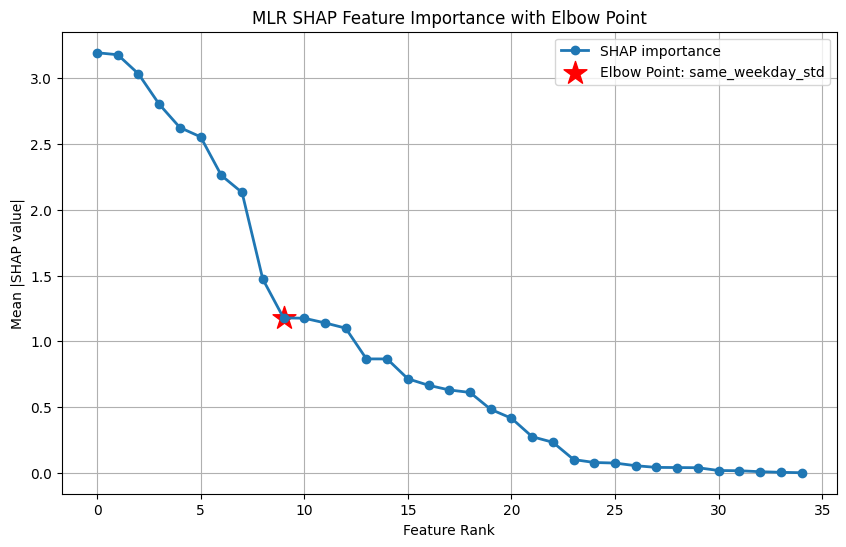

--------------------------------------------------------------------------------------------------------------------------------
forecast_model : svr
Power (MW): 4.038197
lag_1: 3.868456
lag_2: 3.742838
lag_3: 3.556889
lag_4: 3.396200
lag_5: 3.234097
lag_6: 2.948702
lag_7: 2.663420
diff_105min: 2.071583
diff_90min: 1.908426
diff_75min: 1.654153
same_time_mean: 1.624954
diff_60min: 1.540529
Total solar irradiance (W/m2): 1.523485
same_time_max: 1.512237
lag_8: 1.443575
hour_sin: 1.419814
diff_45min: 1.327233
hour_cos: 1.232212
same_time_std: 1.221152
same_weekday_std: 1.186842
diff_30min: 1.078402
same_weekday_mean: 1.061975
diff_15min: 0.963858
overall_mean: 0.910354
same_weekday_max: 0.906584
overall_std: 0.905693
same_time_min: 0.862848
month_cos: 0.807252
month_sin: 0.702434
overall_min: 0.603867
same_weekday_min: 0.599722
Air temperature  (°C) : 0.449574
overall_max: 0.418557
Atmosphere (hpa): 0.192373


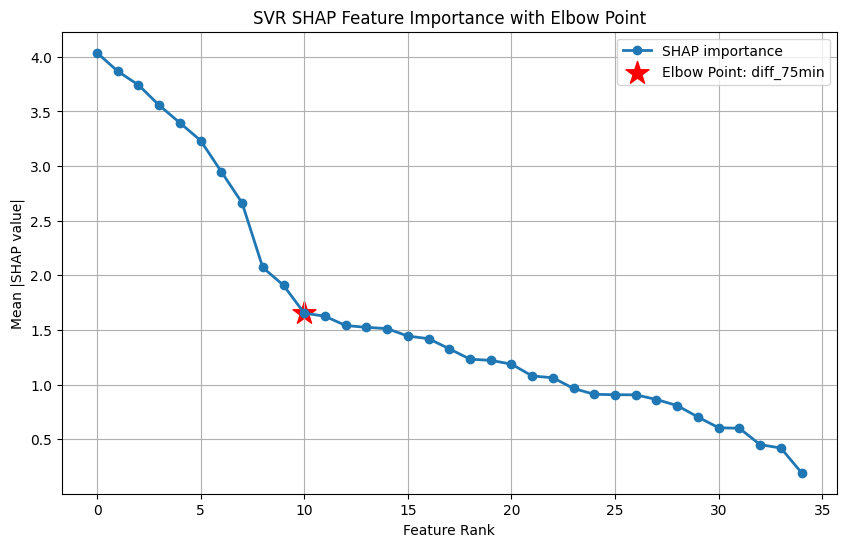

--------------------------------------------------------------------------------------------------------------------------------
forecast_model : lgb

[LGB Feature Importance (SHAP)]
Power (MW): 19.428718
hour_sin: 1.390277
lag_1: 1.186646
lag_2: 0.360177
diff_105min: 0.201724
same_time_mean: 0.167870
lag_3: 0.165967
Total solar irradiance (W/m2): 0.156288
same_time_max: 0.152152
diff_15min: 0.139408
lag_7: 0.103345
diff_90min: 0.100542
diff_75min: 0.086892
diff_60min: 0.075252
diff_45min: 0.071213
lag_8: 0.069870
lag_5: 0.064101
diff_30min: 0.060279
month_cos: 0.052768
lag_6: 0.052669
lag_4: 0.039041
same_weekday_mean: 0.037080
overall_mean: 0.033676
overall_max: 0.033007
Air temperature  (°C) : 0.031660
Atmosphere (hpa): 0.031590
same_time_std: 0.026629
same_time_min: 0.022160
overall_std: 0.022132
month_sin: 0.018693
same_weekday_min: 0.016773
same_weekday_std: 0.016318
same_weekday_max: 0.012886
overall_min: 0.010318
hour_cos: 0.004710


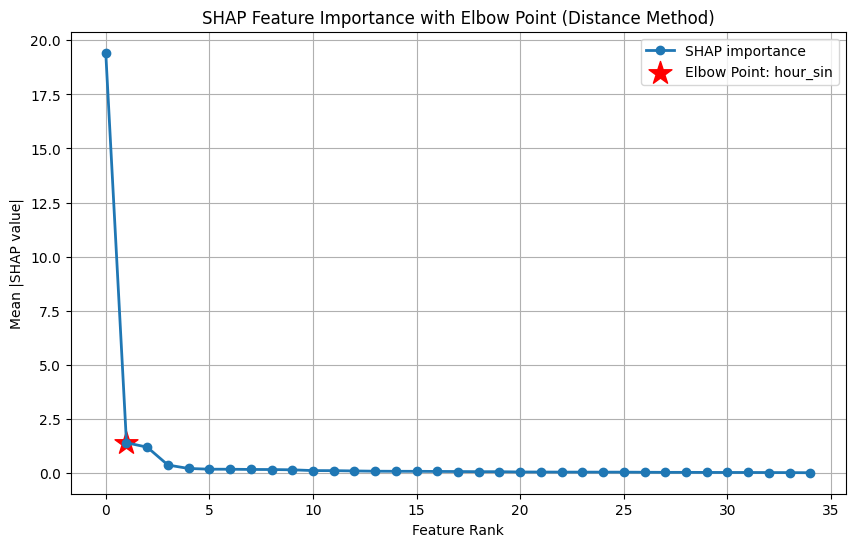

--------------------------------------------------------------------------------------------------------------------------------
forecast_model : mlp


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)



[MLP Feature Importance (SHAP)]
lag_5: 2.864490
lag_2: 2.663449
lag_3: 2.432018
lag_4: 2.272278
lag_1: 2.222846
Power (MW): 2.030353
lag_6: 1.996742
hour_cos: 1.876614
lag_7: 1.595176
hour_sin: 1.384589
diff_90min: 0.605549
diff_105min: 0.546702
diff_60min: 0.538989
diff_75min: 0.443154
diff_45min: 0.290062
same_time_max: 0.192235
Total solar irradiance (W/m2): 0.148001
same_time_mean: 0.103042
same_weekday_std: 0.084484
diff_30min: 0.077623
diff_15min: 0.028144
same_weekday_mean: 0.023203
overall_std: 0.021982
month_cos: 0.015535
overall_min: 0.014933
month_sin: 0.010004
lag_8: 0.007866
same_time_std: 0.007071
overall_mean: 0.006848
same_weekday_min: 0.003677
overall_max: 0.003251
same_time_min: 0.002762
Air temperature  (°C) : 0.000655
same_weekday_max: 0.000387
Atmosphere (hpa): 0.000086


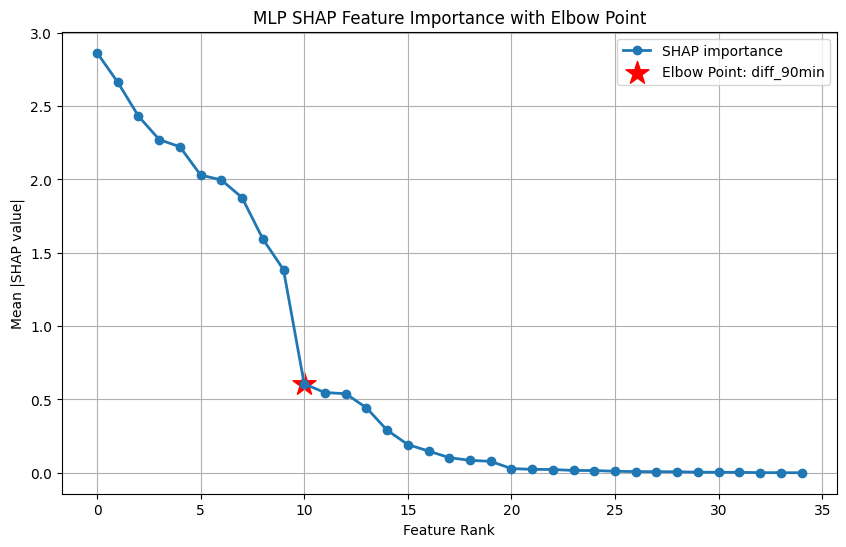

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
site : 5
--------------------------------------------------------------------------------------------------------------------------------
forecast_model : mlr

[MLR Feature Importance (SHAP)]
lag_1: 2.827128
Power (MW): 2.773716
lag_2: 2.653206
lag_3: 2.533650
lag_4: 2.430426
lag_5: 2.160384
lag_6: 2.120303
lag_7: 1.766440
diff_105min: 1.248857
same_weekday_std: 1.127943
lag_8: 1.042166
same_weekday_mean: 1.038917
diff_75min: 1.019734
Total solar irradiance (W/m2): 0.867361
diff_90min: 0.864288
diff_60min: 0.694262
hour_sin: 0.688796
hour_cos: 0.609614
Atmosphere (hpa): 0.554788
diff_45min: 0.446883
same_time_mean: 0.373752
Air temperature  (°C) : 0.323200
same_time_max: 0.298746
diff_30min: 0.276403
month_cos: 0.263643
same_weekday_max: 0.234684
overall_min: 0.179329
same_weekday_min: 0.171243
same_time_min: 0.146269
diff_15min: 0.092604
overall_max: 0.017399
month_sin: 0

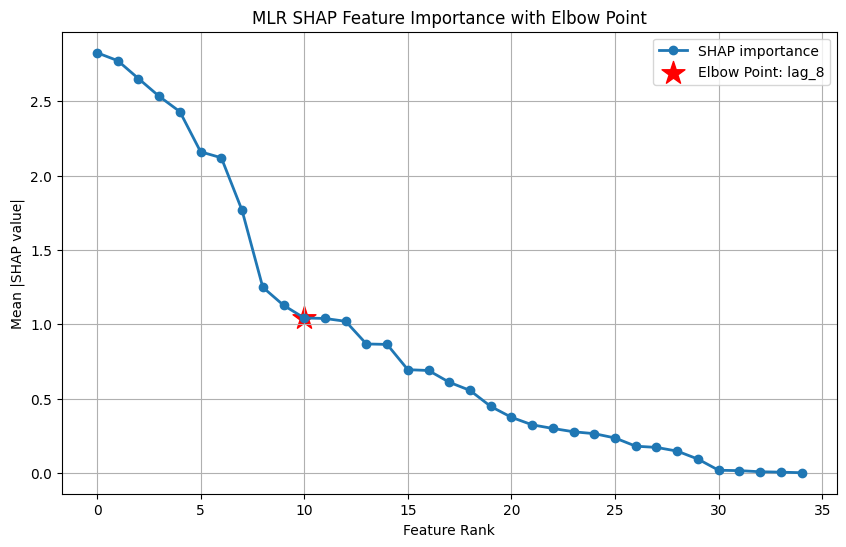

--------------------------------------------------------------------------------------------------------------------------------
forecast_model : svr
Power (MW): 3.536177
lag_1: 3.363614
lag_2: 3.276385
lag_3: 3.055852
lag_4: 2.925822
lag_5: 2.728428
lag_6: 2.579935
lag_7: 2.294985
diff_105min: 1.760846
Total solar irradiance (W/m2): 1.746659
diff_90min: 1.559767
diff_75min: 1.472776
hour_sin: 1.377861
same_time_max: 1.360381
same_time_mean: 1.358659
diff_60min: 1.259981
lag_8: 1.185736
hour_cos: 1.143584
diff_45min: 1.137648
same_weekday_std: 1.093187
same_time_std: 1.045399
same_weekday_mean: 0.946097
diff_30min: 0.874213
overall_std: 0.805978
diff_15min: 0.790312
overall_mean: 0.785173
Air temperature  (°C) : 0.763378
same_weekday_max: 0.762665
month_cos: 0.737647
same_time_min: 0.725777
overall_min: 0.673880
same_weekday_min: 0.637246
month_sin: 0.619206
Atmosphere (hpa): 0.468180
overall_max: 0.326828


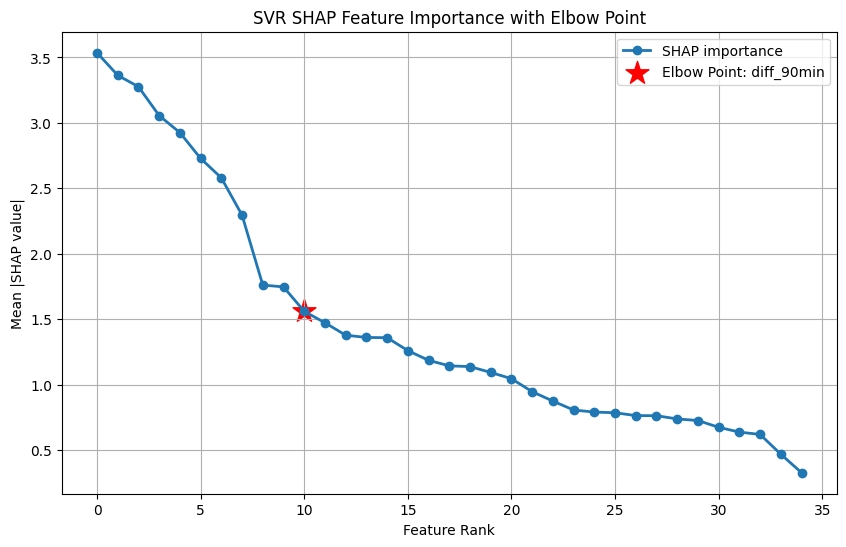

--------------------------------------------------------------------------------------------------------------------------------
forecast_model : lgb

[LGB Feature Importance (SHAP)]
Power (MW): 16.251927
lag_1: 1.554033
hour_sin: 1.272216
lag_2: 0.354684
lag_3: 0.300122
diff_105min: 0.181189
Total solar irradiance (W/m2): 0.159676
same_time_max: 0.142262
same_time_mean: 0.135889
diff_90min: 0.106472
diff_30min: 0.098850
diff_15min: 0.096026
diff_75min: 0.093243
lag_8: 0.089517
lag_6: 0.073370
same_time_min: 0.071471
month_cos: 0.070183
lag_7: 0.069947
Atmosphere (hpa): 0.068843
lag_4: 0.060663
Air temperature  (°C) : 0.048964
same_time_std: 0.039701
diff_45min: 0.039662
diff_60min: 0.039183
lag_5: 0.030173
month_sin: 0.026463
same_weekday_std: 0.024756
overall_max: 0.023938
same_weekday_mean: 0.022821
overall_std: 0.018747
same_weekday_max: 0.018548
overall_mean: 0.017029
hour_cos: 0.007878
overall_min: 0.005803
same_weekday_min: 0.003983


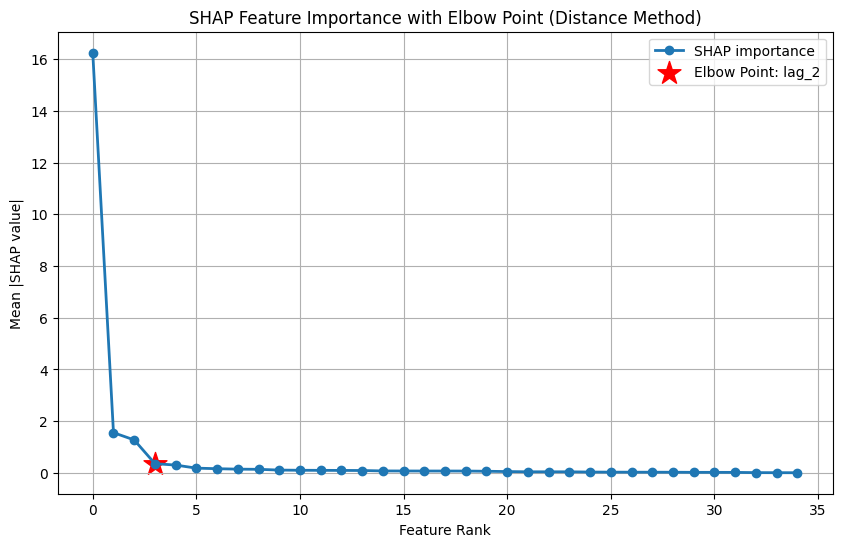

--------------------------------------------------------------------------------------------------------------------------------
forecast_model : mlp


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)



[MLP Feature Importance (SHAP)]
lag_3: 2.394624
lag_2: 2.286300
lag_4: 2.032842
lag_5: 1.973806
hour_cos: 1.891334
lag_1: 1.830464
Power (MW): 1.757712
lag_6: 1.728325
hour_sin: 1.163491
lag_7: 1.101225
diff_75min: 0.868727
diff_105min: 0.384677
diff_90min: 0.361316
diff_60min: 0.302921
same_time_max: 0.254456
same_time_std: 0.185299
Total solar irradiance (W/m2): 0.130193
diff_30min: 0.077007
same_weekday_max: 0.057990
diff_45min: 0.051874
month_cos: 0.049568
same_time_mean: 0.044092
same_weekday_min: 0.040276
same_weekday_std: 0.039631
diff_15min: 0.027869
overall_min: 0.026504
same_weekday_mean: 0.019122
lag_8: 0.017904
overall_mean: 0.016160
overall_std: 0.015178
same_time_min: 0.010931
overall_max: 0.007837
Air temperature  (°C) : 0.006553
month_sin: 0.004695
Atmosphere (hpa): 0.003819


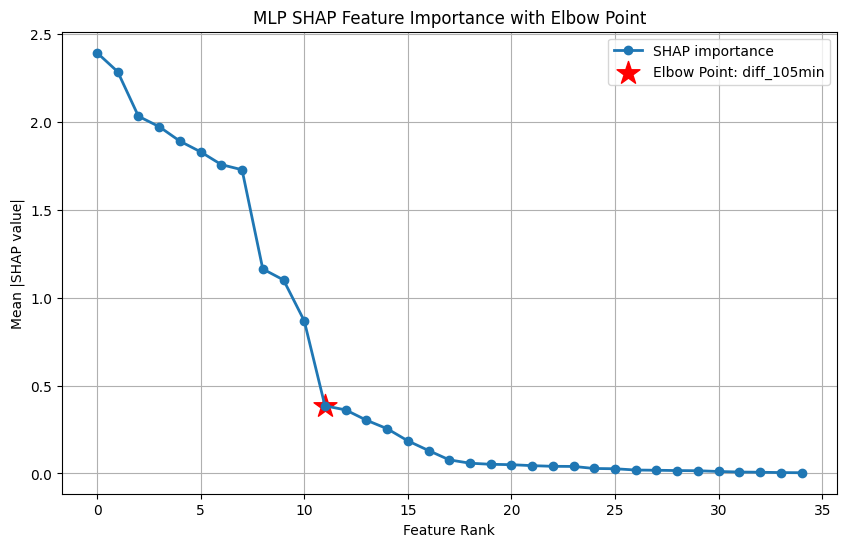

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
site : 6
--------------------------------------------------------------------------------------------------------------------------------
forecast_model : mlr

[MLR Feature Importance (SHAP)]
Power (MW): 1.270278
lag_2: 1.253575
lag_1: 1.226302
lag_3: 1.125616
lag_4: 1.122503
lag_5: 1.006293
Total solar irradiance (W/m2): 0.957177
lag_6: 0.928132
lag_7: 0.920642
lag_8: 0.589527
same_time_mean: 0.568098
diff_90min: 0.405053
diff_75min: 0.391559
diff_105min: 0.380658
hour_cos: 0.308890
same_weekday_mean: 0.293076
diff_45min: 0.280563
diff_60min: 0.269699
same_weekday_std: 0.245675
same_time_max: 0.229415
diff_15min: 0.206560
same_time_std: 0.141477
diff_30min: 0.134149
hour_sin: 0.121352
overall_mean: 0.118901
overall_std: 0.087671
month_cos: 0.081635
same_time_min: 0.055448
month_sin: 0.054097
Air temperature  (°C) : 0.043339
same_weekday_max: 0.005831
overall_max: 0.001731

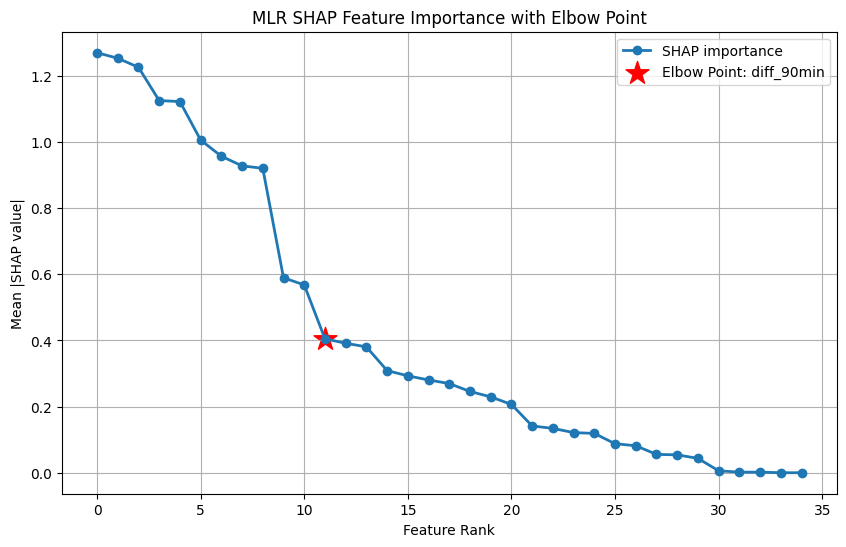

--------------------------------------------------------------------------------------------------------------------------------
forecast_model : svr
Power (MW): 1.442432
lag_2: 1.342087
lag_1: 1.327522
lag_3: 1.254043
lag_4: 1.188683
lag_5: 1.104978
lag_6: 1.043935
lag_7: 0.917727
diff_105min: 0.732686
same_time_max: 0.627618
diff_90min: 0.603124
diff_75min: 0.581281
hour_cos: 0.531428
same_time_mean: 0.514049
diff_60min: 0.510917
diff_15min: 0.510255
diff_45min: 0.439908
hour_sin: 0.408176
same_time_std: 0.405116
lag_8: 0.401048
Total solar irradiance (W/m2): 0.399492
same_weekday_std: 0.374996
overall_std: 0.324328
same_weekday_mean: 0.315361
same_time_min: 0.314505
diff_30min: 0.307027
overall_mean: 0.294862
same_weekday_max: 0.252146
month_cos: 0.245389
month_sin: 0.225775
Air temperature  (°C) : 0.168925
Atmosphere (hpa): 0.104279
overall_max: 0.097138
same_weekday_min: 0.000000
overall_min: 0.000000


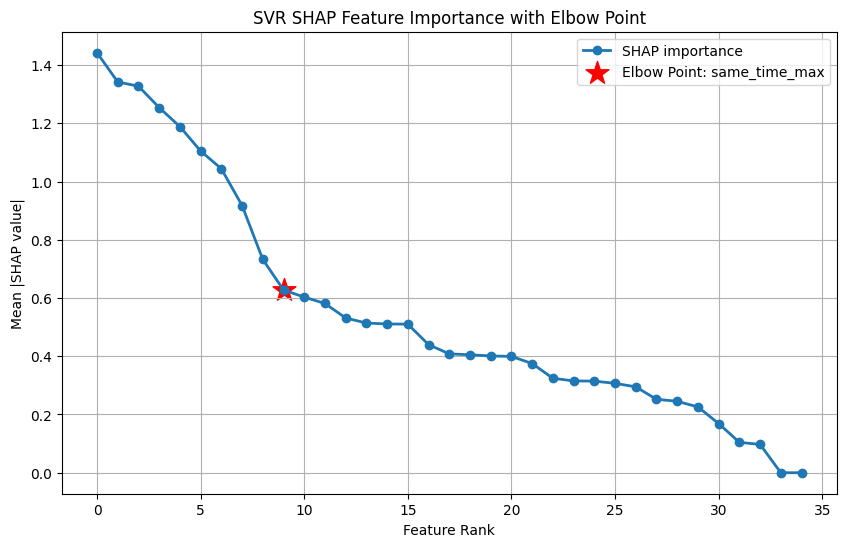

--------------------------------------------------------------------------------------------------------------------------------
forecast_model : lgb

[LGB Feature Importance (SHAP)]
Power (MW): 7.217397
hour_sin: 0.289518
lag_2: 0.167938
hour_cos: 0.166194
diff_15min: 0.118596
Total solar irradiance (W/m2): 0.097019
diff_105min: 0.075691
lag_4: 0.068872
same_time_mean: 0.064928
same_time_max: 0.062526
lag_1: 0.048422
diff_90min: 0.042636
lag_5: 0.038397
lag_7: 0.033551
lag_6: 0.024006
Air temperature  (°C) : 0.023729
diff_45min: 0.022978
lag_3: 0.021566
diff_30min: 0.020246
diff_75min: 0.017222
overall_std: 0.016658
lag_8: 0.015506
diff_60min: 0.015399
overall_max: 0.013571
same_weekday_std: 0.010012
month_cos: 0.009555
same_weekday_max: 0.009543
same_time_std: 0.008715
Atmosphere (hpa): 0.008704
same_weekday_mean: 0.007381
same_time_min: 0.006858
overall_mean: 0.005926
month_sin: 0.002794
same_weekday_min: 0.000000
overall_min: 0.000000


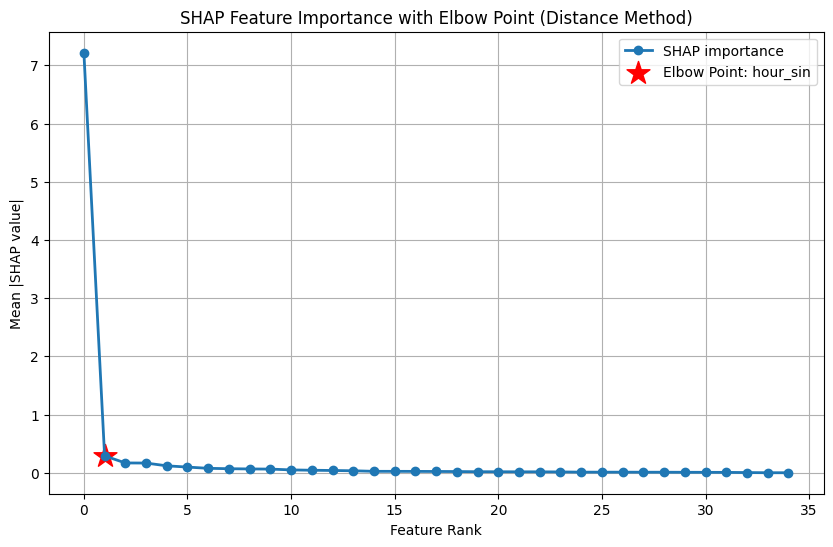

--------------------------------------------------------------------------------------------------------------------------------
forecast_model : mlp


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)



[MLP Feature Importance (SHAP)]
lag_2: 1.085280
lag_3: 1.071580
Power (MW): 0.938685
hour_cos: 0.812889
lag_6: 0.730453
lag_4: 0.717942
lag_5: 0.685258
lag_1: 0.643846
lag_7: 0.571380
diff_75min: 0.298814
diff_105min: 0.206222
diff_90min: 0.177576
Total solar irradiance (W/m2): 0.159814
diff_45min: 0.143165
diff_15min: 0.118550
same_time_max: 0.118282
diff_60min: 0.114698
same_time_mean: 0.094993
hour_sin: 0.053198
diff_30min: 0.042909
same_time_std: 0.022901
overall_std: 0.012585
lag_8: 0.010902
overall_mean: 0.009916
same_weekday_std: 0.005732
same_weekday_max: 0.001945
Atmosphere (hpa): 0.001772
Air temperature  (°C) : 0.001608
same_time_min: 0.001160
month_cos: 0.000552
overall_max: 0.000430
same_weekday_mean: 0.000161
month_sin: 0.000028
same_weekday_min: 0.000000
overall_min: 0.000000


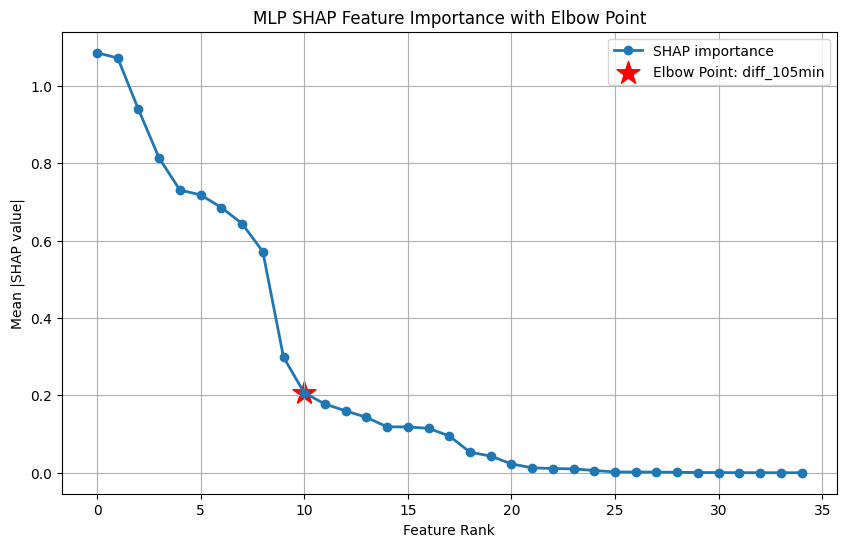

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
site : 7
--------------------------------------------------------------------------------------------------------------------------------
forecast_model : mlr

[MLR Feature Importance (SHAP)]
Power (MW): 1.008048
lag_2: 0.972808
lag_1: 0.947653
lag_3: 0.846167
lag_4: 0.824024
lag_6: 0.755495
lag_5: 0.733455
lag_7: 0.628912
Total solar irradiance (W/m2): 0.575284
same_time_mean: 0.532055
diff_105min: 0.374300
diff_75min: 0.343888
hour_cos: 0.301087
lag_8: 0.276365
diff_90min: 0.266060
diff_60min: 0.234702
diff_45min: 0.234409
same_time_std: 0.216120
same_weekday_mean: 0.209498
hour_sin: 0.182214
same_weekday_std: 0.160765
diff_15min: 0.150366
same_time_min: 0.101485
diff_30min: 0.099322
same_time_max: 0.070948
month_sin: 0.044307
overall_mean: 0.039960
Atmosphere (hpa): 0.015075
month_cos: 0.004573
same_weekday_max: 0.004292
overall_max: 0.000796
overall_std: 0.000186
Air t

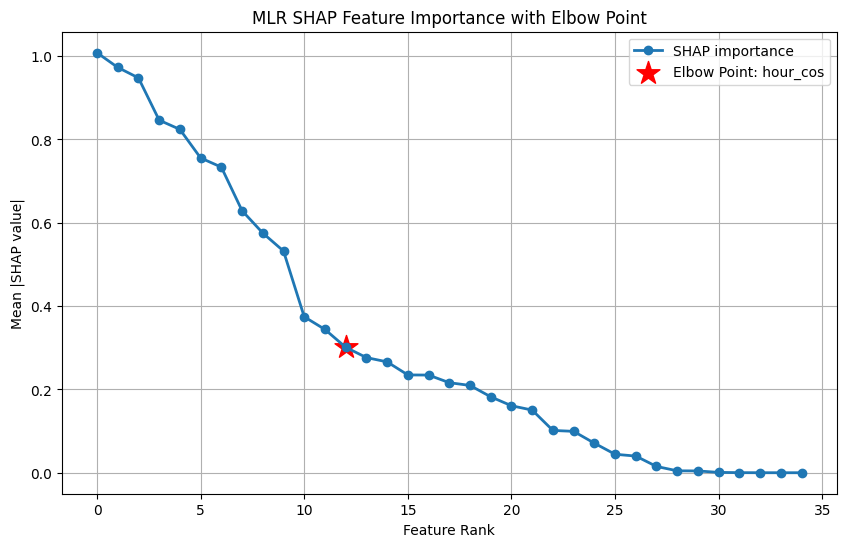

--------------------------------------------------------------------------------------------------------------------------------
forecast_model : svr
Power (MW): 1.267513
lag_2: 1.151694
lag_1: 1.117481
lag_3: 1.041668
lag_4: 0.994064
lag_5: 0.907633
lag_6: 0.880757
lag_7: 0.782008
diff_105min: 0.645249
diff_75min: 0.560118
same_time_max: 0.557911
diff_90min: 0.546659
hour_cos: 0.496501
diff_60min: 0.473062
diff_15min: 0.464260
diff_45min: 0.434814
same_time_mean: 0.406746
hour_sin: 0.392732
Total solar irradiance (W/m2): 0.381885
same_time_std: 0.357303
lag_8: 0.338811
same_weekday_std: 0.327866
diff_30min: 0.284965
same_time_min: 0.278498
overall_std: 0.272206
overall_mean: 0.262236
same_weekday_mean: 0.256332
month_cos: 0.230401
same_weekday_max: 0.201198
month_sin: 0.195494
Air temperature  (°C) : 0.153814
Atmosphere (hpa): 0.093613
overall_max: 0.092998
same_weekday_min: 0.000000
overall_min: 0.000000


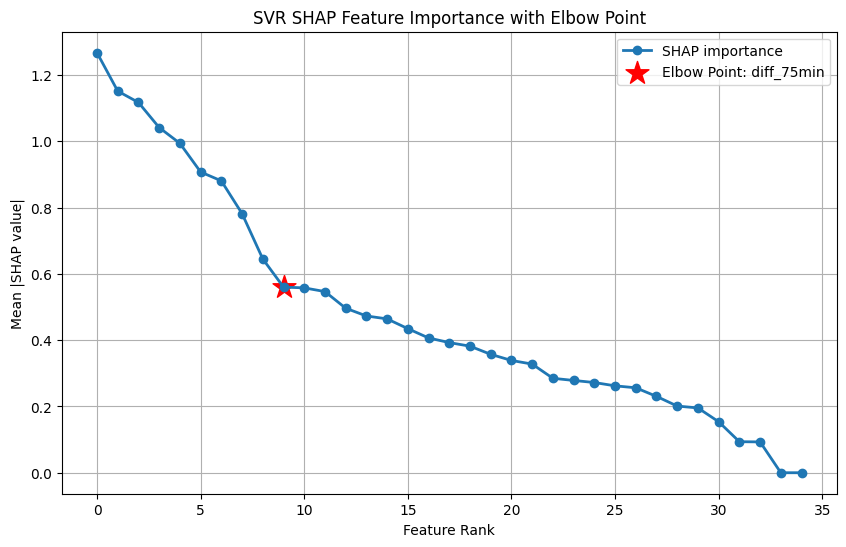

--------------------------------------------------------------------------------------------------------------------------------
forecast_model : lgb

[LGB Feature Importance (SHAP)]
Power (MW): 6.099998
hour_sin: 0.280316
hour_cos: 0.186603
lag_2: 0.158080
diff_15min: 0.152368
same_time_max: 0.065240
lag_8: 0.058638
lag_3: 0.053033
diff_105min: 0.047753
Air temperature  (°C) : 0.046906
Total solar irradiance (W/m2): 0.041937
same_time_mean: 0.039094
diff_90min: 0.032944
lag_5: 0.031596
lag_6: 0.030590
lag_1: 0.030067
lag_4: 0.026286
diff_30min: 0.023700
overall_std: 0.019539
diff_75min: 0.018326
same_weekday_std: 0.017578
lag_7: 0.016973
diff_60min: 0.014951
same_time_min: 0.014799
same_weekday_mean: 0.012536
Atmosphere (hpa): 0.012220
month_cos: 0.011076
diff_45min: 0.009627
same_time_std: 0.008634
same_weekday_max: 0.008111
overall_max: 0.006925
overall_mean: 0.005452
month_sin: 0.003596
same_weekday_min: 0.000000
overall_min: 0.000000


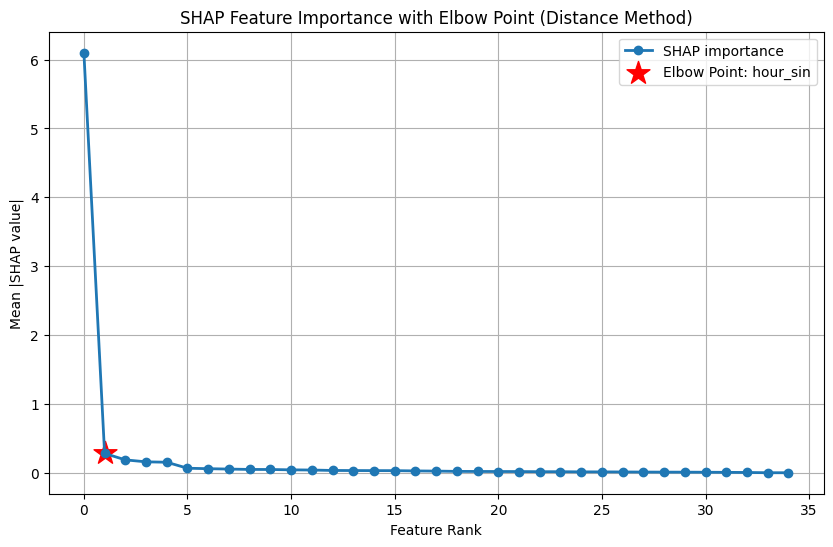

--------------------------------------------------------------------------------------------------------------------------------
forecast_model : mlp


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)



[MLP Feature Importance (SHAP)]
hour_cos: 0.959614
lag_2: 0.916912
lag_3: 0.830015
lag_6: 0.641548
Power (MW): 0.638802
lag_5: 0.564289
lag_4: 0.459330
lag_7: 0.374567
same_time_mean: 0.346475
diff_105min: 0.314713
lag_1: 0.307533
diff_75min: 0.239549
diff_45min: 0.191407
diff_90min: 0.149261
hour_sin: 0.117883
diff_15min: 0.098655
diff_60min: 0.078787
same_time_max: 0.076860
diff_30min: 0.057677
lag_8: 0.028778
Total solar irradiance (W/m2): 0.026097
month_sin: 0.014239
month_cos: 0.011855
Air temperature  (°C) : 0.008169
same_weekday_std: 0.007784
same_time_std: 0.006802
same_weekday_mean: 0.004463
same_time_min: 0.003503
overall_std: 0.003028
overall_mean: 0.003016
overall_max: 0.001769
same_weekday_max: 0.001056
Atmosphere (hpa): 0.000674
same_weekday_min: 0.000000
overall_min: 0.000000


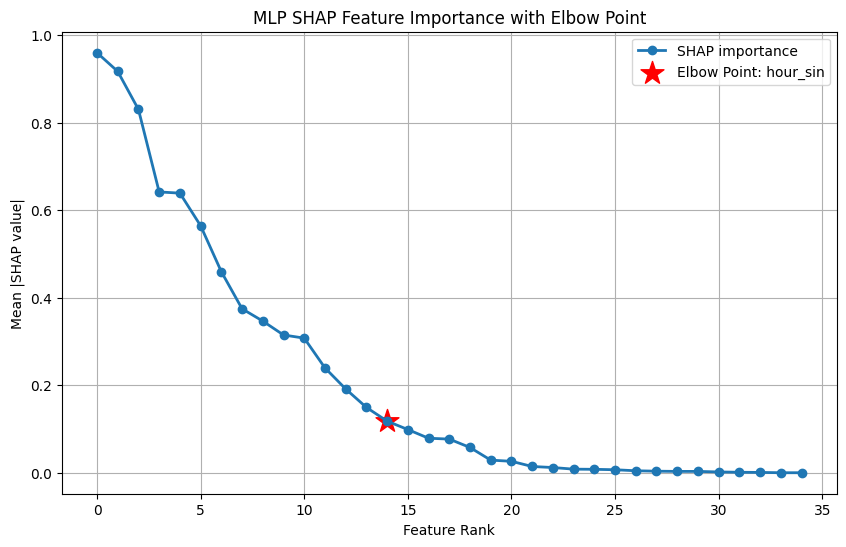

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
site : 8
--------------------------------------------------------------------------------------------------------------------------------
forecast_model : mlr

[MLR Feature Importance (SHAP)]
lag_1: 0.713551
lag_2: 0.693777
Power (MW): 0.690647
lag_3: 0.645509
lag_4: 0.587765
lag_5: 0.540383
lag_6: 0.476356
lag_7: 0.453770
diff_90min: 0.331369
diff_105min: 0.329274
same_time_max: 0.282951
hour_cos: 0.263519
diff_75min: 0.262500
lag_8: 0.226737
diff_60min: 0.218653
same_weekday_mean: 0.190850
same_weekday_std: 0.180991
diff_45min: 0.118212
same_time_mean: 0.113931
Total solar irradiance (W/m2): 0.113730
diff_15min: 0.106513
hour_sin: 0.065736
overall_std: 0.048677
overall_mean: 0.034051
same_weekday_max: 0.030296
same_time_std: 0.019930
overall_max: 0.012290
Air temperature  (°C) : 0.007357
diff_30min: 0.007081
month_sin: 0.006522
month_cos: 0.005646
Atmosphere (hpa): 0.002

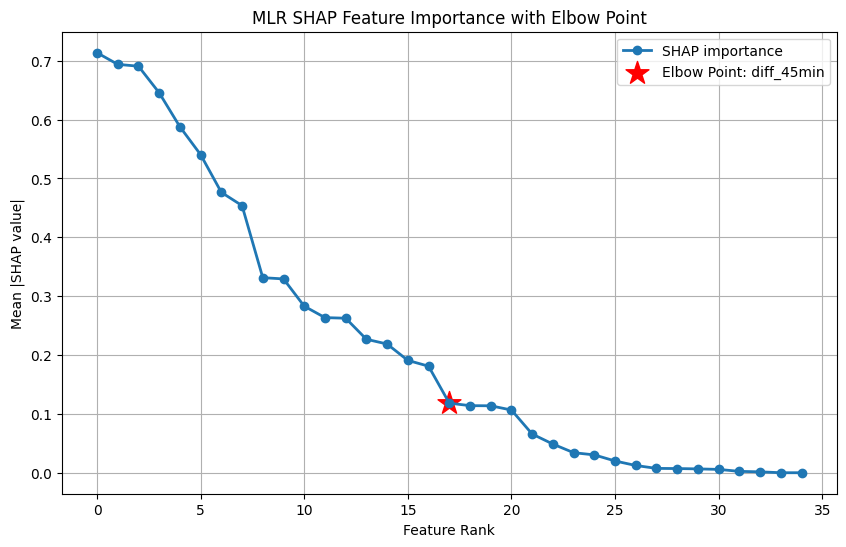

--------------------------------------------------------------------------------------------------------------------------------
forecast_model : svr
Power (MW): 1.027224
lag_1: 1.010309
lag_2: 0.971888
lag_3: 0.933803
lag_4: 0.885619
lag_5: 0.833436
lag_6: 0.766881
lag_7: 0.683816
diff_105min: 0.592908
diff_90min: 0.517642
diff_75min: 0.489148
same_time_mean: 0.453687
hour_sin: 0.433773
diff_60min: 0.429760
same_time_max: 0.380912
Total solar irradiance (W/m2): 0.380153
lag_8: 0.373716
same_weekday_max: 0.372750
same_weekday_std: 0.366392
diff_45min: 0.359934
hour_cos: 0.358652
same_weekday_mean: 0.353670
same_time_std: 0.337064
overall_std: 0.311542
diff_30min: 0.308224
overall_mean: 0.276998
same_time_min: 0.256138
diff_15min: 0.248932
month_cos: 0.226760
month_sin: 0.203119
overall_max: 0.151973
Air temperature  (°C) : 0.114403
Atmosphere (hpa): 0.048119
same_weekday_min: 0.000000
overall_min: 0.000000


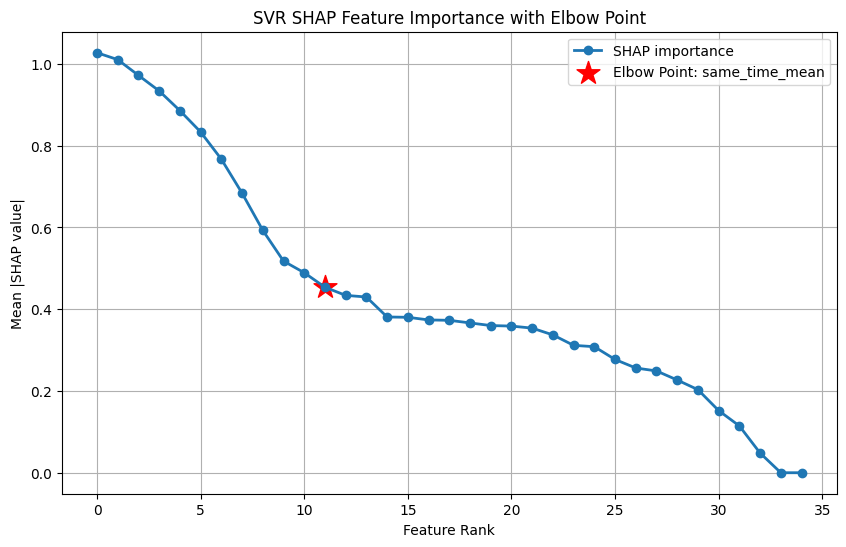

--------------------------------------------------------------------------------------------------------------------------------
forecast_model : lgb

[LGB Feature Importance (SHAP)]
Power (MW): 4.670075
lag_1: 0.410559
hour_sin: 0.252539
diff_105min: 0.150924
lag_2: 0.054599
lag_8: 0.048341
Total solar irradiance (W/m2): 0.046677
same_time_max: 0.036854
diff_90min: 0.032905
diff_75min: 0.028843
diff_30min: 0.024452
diff_15min: 0.017674
lag_3: 0.016902
overall_max: 0.012643
diff_60min: 0.012488
month_cos: 0.012161
same_time_mean: 0.010245
diff_45min: 0.009571
same_time_min: 0.009227
Air temperature  (°C) : 0.007933
lag_4: 0.007628
lag_5: 0.007576
same_weekday_max: 0.007344
lag_6: 0.006680
month_sin: 0.006503
lag_7: 0.006313
same_time_std: 0.003846
same_weekday_mean: 0.003669
same_weekday_std: 0.003378
overall_std: 0.003000
overall_mean: 0.002347
Atmosphere (hpa): 0.001789
hour_cos: 0.001438
same_weekday_min: 0.000000
overall_min: 0.000000


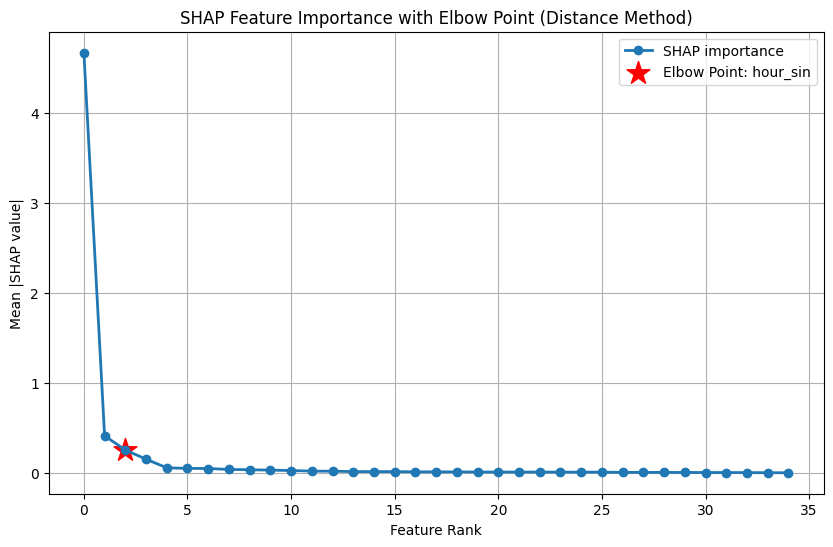

--------------------------------------------------------------------------------------------------------------------------------
forecast_model : mlp


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)



[MLP Feature Importance (SHAP)]
Power (MW): 0.718384
lag_2: 0.711449
lag_3: 0.684020
hour_cos: 0.568761
lag_5: 0.546184
lag_7: 0.452543
lag_6: 0.429679
lag_1: 0.383832
lag_4: 0.319051
hour_sin: 0.246661
diff_105min: 0.220890
diff_75min: 0.151125
same_time_std: 0.121578
diff_90min: 0.109178
diff_60min: 0.067921
diff_45min: 0.043879
same_time_mean: 0.043227
Total solar irradiance (W/m2): 0.031482
lag_8: 0.017081
diff_30min: 0.017013
same_time_max: 0.004135
same_time_min: 0.003723
diff_15min: 0.002102
overall_std: 0.000963
same_weekday_std: 0.000893
same_weekday_mean: 0.000723
same_weekday_max: 0.000295
overall_max: 0.000231
overall_mean: 0.000154
Air temperature  (°C) : 0.000064
Atmosphere (hpa): 0.000041
month_cos: 0.000012
month_sin: 0.000000
same_weekday_min: 0.000000
overall_min: 0.000000


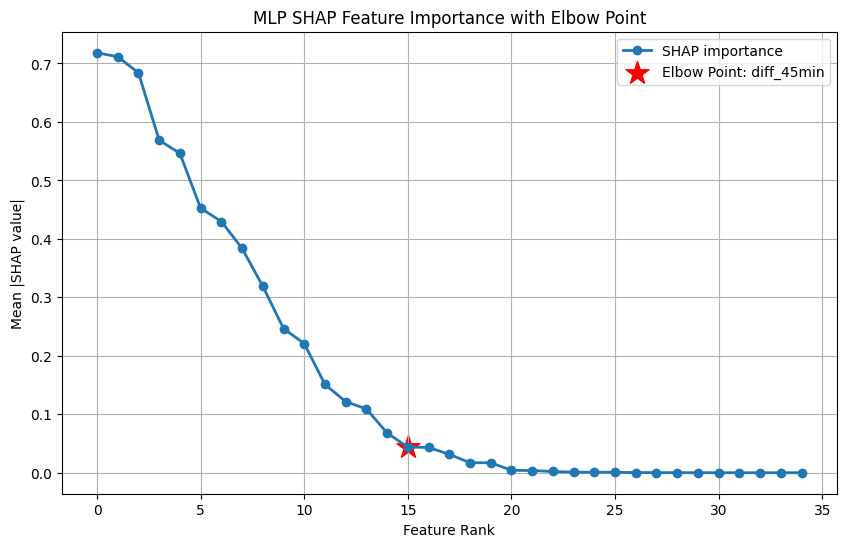

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
import multiprocessing


forecast_models = ['mlr','svr','lgb', 'mlp']

files = sorted([os.path.join(path+'/result_of_paper/ann/', file) for file in os.listdir(path+'/result_of_paper/ann/') if file.endswith('.csv') and 'mlr' in file])

df_list = []

for file in files:
  df_list.append(pd.read_csv(file))

test_size = 2/24

for df, site in zip(df_list, [1,2,4,5,6,7,8]):
  print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
  print(f'site : {site}')
  target = 'Power (MW)'
  shifted_target = 'power_shifted'

  df_copy = df.copy()
  df_copy[shifted_target] = df_copy[target].shift(-1)
  df_copy = df_copy.dropna().reset_index(drop=True)

  split_index = int(len(df_copy) * (1 - test_size))

  X = df_copy[features]
  y = df_copy[shifted_target]
  X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
  y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
  X_test_scaled = scaler.transform(X_test)
  X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

  forecast_mlr = joblib.load(f"{path}/result_of_paper/ann/mlr_forecasting_model_{str(site)}.joblib")
  forecast_svr = joblib.load(f"{path}/result_of_paper/ann/svr_forecasting_model_{str(site)}.joblib")
  forecast_lgb_model = lgb.Booster(model_file=f"{path}/result_of_paper/ann/lgb_forecasting_model_{str(site)}.txt")
  forecast_mlp = joblib.load(f"{path}/result_of_paper/ann/mlp_forecasting_model_{str(site)}.joblib")

  for forecast_model in ['mlr','svr','lgb','mlp']:
    print('--------------------------------------------------------------------------------------------------------------------------------')
    print(f'forecast_model : {forecast_model}')

    if forecast_model == 'mlr':
        # ------------------- MLR -------------------
        explainer_mlr = shap.Explainer(forecast_mlr, X_train_scaled_df)
        shap_values_mlr = explainer_mlr(X_train_scaled_df)

        shap_importance = np.abs(shap_values_mlr.values).mean(axis=0)

        shap_df = pd.DataFrame({
            'feature': X_train.columns,
            'mean_abs_shap': shap_importance
        }).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

        print("\n[MLR Feature Importance (SHAP)]")
        for _, row in shap_df.iterrows():
          print(f"{row['feature']}: {row['mean_abs_shap']:.6f}")

        # elbow point
        x = np.arange(len(shap_df))
        y = shap_df['mean_abs_shap'].values
        x_scaled = MinMaxScaler().fit_transform(x.reshape(-1, 1)).flatten()
        y_scaled = MinMaxScaler().fit_transform(y.reshape(-1, 1)).flatten()

        start = np.array([x_scaled[0], y_scaled[0]])
        end = np.array([x_scaled[-1], y_scaled[-1]])

        line_vec = end - start
        line_vec_norm = line_vec / np.linalg.norm(line_vec)
        point_vecs = np.stack([x_scaled - start[0], y_scaled - start[1]], axis=1)
        projections = np.dot(point_vecs, line_vec_norm)
        projected_points = np.outer(projections, line_vec_norm) + start
        distances = np.linalg.norm(point_vecs - projected_points, axis=1)

        elbow_idx = np.argmax(distances)
        elbow_feature = shap_df.loc[elbow_idx, 'feature']
        elbow_value = shap_df.loc[elbow_idx, 'mean_abs_shap']

        plt.figure(figsize=(10, 6))
        plt.plot(x, y, marker='o', label='SHAP importance', linewidth=2)
        plt.scatter(elbow_idx, elbow_value, color='red', marker='*', s=300, label=f'Elbow Point: {elbow_feature}')
        plt.title("MLR SHAP Feature Importance with Elbow Point")
        plt.xlabel("Feature Rank")
        plt.ylabel("Mean |SHAP value|")
        plt.legend()
        plt.grid(True)
        plt.show()

    elif forecast_model == 'svr':
        # ------------------- SVR -------------------
        X_sample_df, y_sample = resample(X_train_scaled_df, y_train, n_samples=5000, random_state=42)
        importance_dict = permutation_importance_per_instance(
            columns=X_sample_df.columns,
            model=forecast_svr,
            X=X_sample_df,
            n_repeats=5,
            n_jobs=-1  # 모든 CPU 코어 사용
        )

        # ▶ 평균 중요도로 정리
        shap_style_df = pd.DataFrame({
            'feature': X_sample_df.columns,
            'mean_abs_shap': [np.mean(np.abs(v)) for v in importance_dict.values()]
        }).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

        # ▶ 출력
        for _, row in shap_style_df.iterrows():
            print(f"{row['feature']}: {row['mean_abs_shap']:.6f}")

        # elbow point
        x = np.arange(len(shap_style_df))
        y = shap_style_df['mean_abs_shap'].values
        x_scaled = MinMaxScaler().fit_transform(x.reshape(-1, 1)).flatten()
        y_scaled = MinMaxScaler().fit_transform(y.reshape(-1, 1)).flatten()

        start = np.array([x_scaled[0], y_scaled[0]])
        end = np.array([x_scaled[-1], y_scaled[-1]])

        line_vec = end - start
        line_vec_norm = line_vec / np.linalg.norm(line_vec)
        point_vecs = np.stack([x_scaled - start[0], y_scaled - start[1]], axis=1)
        projections = np.dot(point_vecs, line_vec_norm)
        projected_points = np.outer(projections, line_vec_norm) + start
        distances = np.linalg.norm(point_vecs - projected_points, axis=1)

        elbow_idx = np.argmax(distances)
        elbow_feature = shap_style_df.loc[elbow_idx, 'feature']
        elbow_value = shap_style_df.loc[elbow_idx, 'mean_abs_shap']

        plt.figure(figsize=(10, 6))
        plt.plot(x, y, marker='o', label='SHAP importance', linewidth=2)
        plt.scatter(elbow_idx, elbow_value, color='red', marker='*', s=300, label=f'Elbow Point: {elbow_feature}')
        plt.title("SVR SHAP Feature Importance with Elbow Point")
        plt.xlabel("Feature Rank")
        plt.ylabel("Mean |SHAP value|")
        plt.legend()
        plt.grid(True)
        plt.show()


    elif forecast_model == 'lgb':
    # ------------------- LGB -------------------explainer_lgb = shap.Explainer(reforecast_lgb_model)

      explainer_lgb = shap.Explainer(forecast_lgb_model)
      shap_values_lgb = explainer_lgb(X_train)

      shap_importance = np.abs(shap_values_lgb.values).mean(axis=0)

      # DataFrame으로 정리
      shap_df = pd.DataFrame({
          'feature': X_test.columns,
          'mean_abs_shap': shap_importance
      }).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

      # 출력
      print("\n[LGB Feature Importance (SHAP)]")
      for _, row in shap_df.iterrows():
          print(f"{row['feature']}: {row['mean_abs_shap']:.6f}")

      # kneedle 알고리즘 사용
      x = np.arange(len(shap_df))
      y = shap_df['mean_abs_shap'].values
      x_scaled = MinMaxScaler().fit_transform(x.reshape(-1, 1)).flatten()
      y_scaled = MinMaxScaler().fit_transform(y.reshape(-1, 1)).flatten()

      # 직선 시작점과 끝점
      start = np.array([x_scaled[0], y_scaled[0]])
      end = np.array([x_scaled[-1], y_scaled[-1]])

      # 각 점에서 직선까지의 수직 거리 계산
      line_vec = end - start
      line_vec_norm = line_vec / np.linalg.norm(line_vec)
      point_vecs = np.stack([x_scaled - start[0], y_scaled - start[1]], axis=1)
      projections = np.dot(point_vecs, line_vec_norm)
      projected_points = np.outer(projections, line_vec_norm) + start
      distances = np.linalg.norm(point_vecs - projected_points, axis=1)

      # 가장 멀리 떨어진 점이 elbow point
      elbow_idx = np.argmax(distances)
      elbow_feature = shap_df.loc[elbow_idx, 'feature']
      elbow_value = shap_df.loc[elbow_idx, 'mean_abs_shap']

      # 시각화
      plt.figure(figsize=(10, 6))
      plt.plot(x, y, marker='o', label='SHAP importance', linewidth=2)
      plt.scatter(elbow_idx, elbow_value, color='red', marker='*', s=300, label=f'Elbow Point: {elbow_feature}')
      plt.title("SHAP Feature Importance with Elbow Point (Distance Method)")
      plt.xlabel("Feature Rank")
      plt.ylabel("Mean |SHAP value|")
      plt.legend()
      plt.grid(True)
      plt.show()

    elif forecast_model == 'mlp':
      # ------------------- MLP -------------------
      def compute_shap_partial(batch):
          explainer = shap.KernelExplainer(forecast_mlp.predict, background)
          return explainer.shap_values(batch)

      X_target = shap.utils.sample(X_train_scaled_df, 2000, random_state=42)
      background = shap.utils.sample(X_target, 100, random_state=42)
      X_batches = np.array_split(X_target, 8)
      with multiprocessing.Pool(processes=8) as pool:
          shap_parts = pool.map(compute_shap_partial, X_batches)
      shap_values_mlp = np.concatenate(shap_parts, axis=0)

      shap_importance = np.abs(shap_values_mlp).mean(axis=0)
      shap_df = pd.DataFrame({
          'feature': X_train_scaled_df.columns,
          'mean_abs_shap': shap_importance
      }).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

      print("\n[MLP Feature Importance (SHAP)]")
      for _, row in shap_df.iterrows():
          print(f"{row['feature']}: {row['mean_abs_shap']:.6f}")

      x = np.arange(len(shap_df))
      y = shap_df['mean_abs_shap'].values
      x_scaled = MinMaxScaler().fit_transform(x.reshape(-1, 1)).flatten()
      y_scaled = MinMaxScaler().fit_transform(y.reshape(-1, 1)).flatten()

      start = np.array([x_scaled[0], y_scaled[0]])
      end = np.array([x_scaled[-1], y_scaled[-1]])
      line_vec = end - start
      line_vec_norm = line_vec / np.linalg.norm(line_vec)
      point_vecs = np.stack([x_scaled - start[0], y_scaled - start[1]], axis=1)
      projections = np.dot(point_vecs, line_vec_norm)
      projected_points = np.outer(projections, line_vec_norm) + start
      distances = np.linalg.norm(point_vecs - projected_points, axis=1)

      elbow_idx = np.argmax(distances)
      elbow_feature = shap_df.loc[elbow_idx, 'feature']
      elbow_value = shap_df.loc[elbow_idx, 'mean_abs_shap']

      plt.figure(figsize=(10, 6))
      plt.plot(x, y, marker='o', label='SHAP importance', linewidth=2)
      plt.scatter(elbow_idx, elbow_value, color='red', marker='*', s=300, label=f'Elbow Point: {elbow_feature}')
      plt.title("MLP SHAP Feature Importance with Elbow Point")
      plt.xlabel("Feature Rank")
      plt.ylabel("Mean |SHAP value|")
      plt.legend()
      plt.grid(True)
      plt.show()
